# Requirements
1. Add a `.env` file in the same directory as the notebook and copy the following content to it:
    ```
    GITHUB_TOKEN=<The github api key>
    ```
2. Set the python environment to run this notebook to `openwpm`

In [1]:
import sys
import os
from pathlib import Path
import pandas as pd
from datetime import datetime
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
import math
import importlib
import re
import requests

# Set the global font to be DejaVu Sans, size 10 (or any other sans-serif font of your choice!)
plt.rc('font', family='serif')
plt.rcParams["patch.force_edgecolor"] = True
sns.set_context("paper")
sns.set(font='serif')

sns.set_style("white", {
    'font.family': 'serif',
    'font.serif': ['Time', 'Palatino', 'serif']
})

def style_ax(ax):
    sns.despine(ax=ax, left=True)


%matplotlib inline

# The following %config line changes the inline figures to have a higher DPI.
# You can comment out (#) this line if you don't have a high-DPI (~220) display.
%config InlineBackend.figure_format = 'retina'

from dotenv import load_dotenv, find_dotenv
load_dotenv()
DOTENV_PATH = find_dotenv()

sys.path.insert(1, os.path.join(os.path.split(os.path.abspath(DOTENV_PATH))[0], ".."))
from BreakageClassifier.code.forums.easylist import builder as easylist
from BreakageClassifier.code.forums.filterlists import generate_filterlists
from BreakageClassifier.code.forums.detect_rule import generate_rule_types_from_file, RuleType
from BreakageClassifier.code.forums.ublock import builder as ublock
from BreakageClassifier.code.forums.ublock.extract_urls import semi_manual_extract_urls as ublock_interactive_extract_urls
from BreakageClassifier.code.forums.utils import URL_REGEX, headers


## Ublock Origin

In [2]:
## CONFIG ##
# The output directory

UBLOCK_LIST_OUTPUT_DIR = Path("./forums-out/ublock")
UBLOCK_INPUT_DIR = Path("../BreakageClassifier/code/forums/ublock/")

### Scraping
We have a scraped dataset in `<project-root>/BreakageClassifier/code/forums/data_uassets.json`

In [ ]:
# if you want to re-generate the dataset
ublock.generate_dataset(
    out_path= UBLOCK_LIST_OUTPUT_DIR, 
    in_data_path = UBLOCK_INPUT_DIR.joinpath("data_uassets.json"),
    in_manual_path = UBLOCK_INPUT_DIR.joinpath("manual_data.json"),
    force = True
)

We need to normalize the data generated by ublock for this experiment to be consistent with easylist dataset.
- change column names
- add post and language

In [118]:
# normalize the dataset
def standarize_dataset():
    df = pd.read_csv(UBLOCK_LIST_OUTPUT_DIR.joinpath("issues.csv"))
    
    if 'url' in df.columns:
        df = df.rename(columns={
            'url': 'test_url',
        })
        
        df = df.drop(columns = [c for c in df.columns if 'unnamed' in c or 'Unnamed' in c])
        df.to_csv(UBLOCK_LIST_OUTPUT_DIR.joinpath("issues.csv"))
              
    if any(df.directories.isna().values):
        df['directories'] = df['directories'].fillna("[]")
        df.to_csv(UBLOCK_LIST_OUTPUT_DIR.joinpath("issues.csv"))
        
        
    df = ublock.generate_details(
            UBLOCK_LIST_OUTPUT_DIR.joinpath("issues.csv"), 
            UBLOCK_INPUT_DIR.joinpath("data_uassets.json"), 
            UBLOCK_LIST_OUTPUT_DIR.joinpath("ublock-data.csv")
        )
    
standarize_dataset()

Number of posts: 638
Number of useful posts: 435
2017-05-29T04:45:07Z
2022-06-03T16:26:00Z
1812 days, 19:35:40


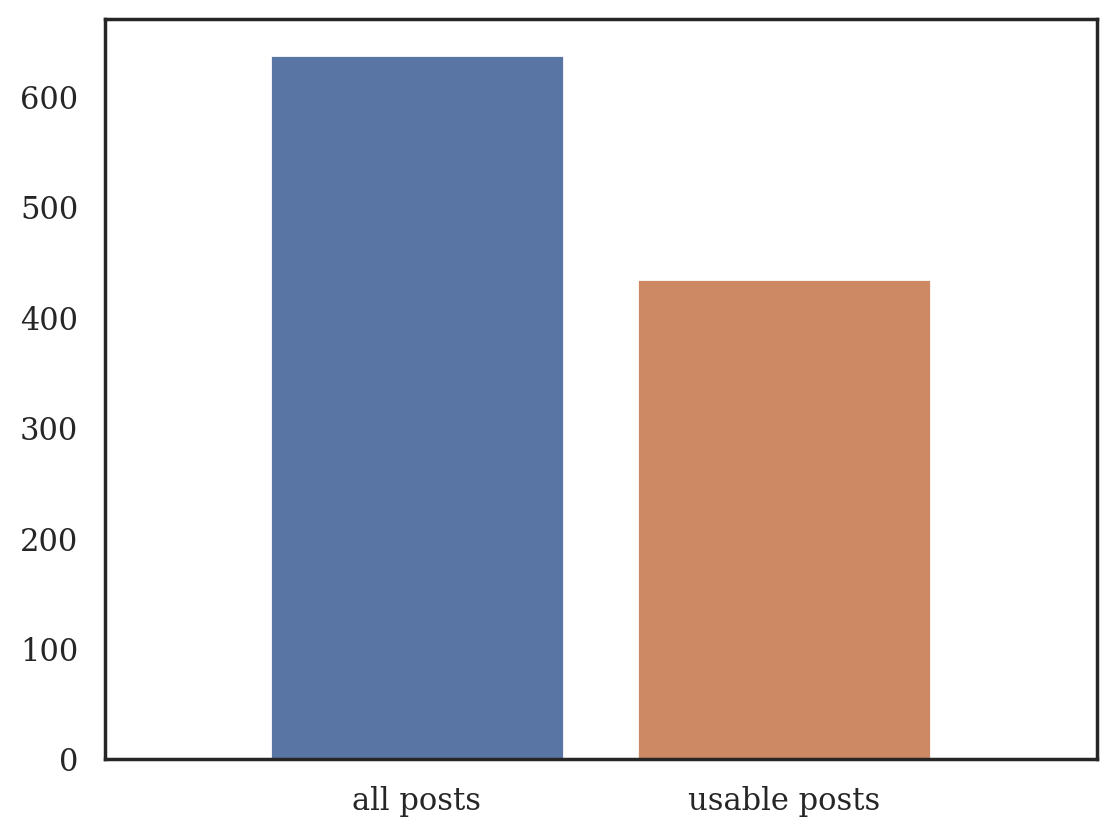

In [20]:
def stat():
    df = pd.read_csv(UBLOCK_LIST_OUTPUT_DIR.joinpath("ublock-data.csv"))
    
    df_good = df[(df['label'] == 'D') | (df['label'] == 'S')]
    
    n_good = len(df[(df['label'] == 'D') | (df['label'] == 'S')])
    print(f"Number of posts: {len(df)}")
    print(f"Number of useful posts: {n_good}")
    
    print(df.created_at.min())
    print(df.created_at.max())
    print(datetime.strptime(df_good.created_at.max(), '%Y-%m-%dT%H:%M:%SZ') - datetime.strptime(df_good.created_at.min(), '%Y-%m-%dT%H:%M:%SZ'))
    fig, ax = plt.subplots()
    
    sns.barplot(y = [len(df), n_good], x = ['all posts', 'usable posts'], ax=ax)
    ax.margins(x=0.25)
    
stat()

In [120]:
# extract test urls
# ublock_interactive_extract_urls(
#     out = UBLOCK_LIST_OUTPUT_DIR,
#     is_force=True
# )

df = pd.read_csv(UBLOCK_LIST_OUTPUT_DIR.joinpath("out_urls.csv"))
df.columns = ['id', 'test_url']
df.to_csv(UBLOCK_LIST_OUTPUT_DIR.joinpath("manual-test-url.csv"), index=False)


Combine the manual parts to the dataset

In [121]:
def update_manual_labels(): 
    df = pd.read_csv(UBLOCK_LIST_OUTPUT_DIR.joinpath("ublock-data.csv"))
    df_tu = pd.read_csv(UBLOCK_LIST_OUTPUT_DIR.joinpath("manual-test-url.csv")).dropna().astype({'id': 'int64'})
    df_rt = pd.read_csv(UBLOCK_LIST_OUTPUT_DIR.joinpath("rule-types.csv")).dropna().astype({'id': 'int64'})
    
    for _, row in df_tu.iterrows():
        df.loc[df['id'] == row.id, 'test_url'] = row.test_url
        
    for _, row in df.iterrows():
        if isinstance(row.test_url, str) and len(row.test_url) > 1 and "://" not in row.test_url:
            df.loc[df['id'] == row.id, 'test_url'] = "https://"+row.test_url
        
    if "rule-type" not in df.columns:
        df = df.merge(df_rt, on='id', how='outer')
    
    df = df.drop(columns = [c for c in df.columns if 'unnamed' in c or 'Unnamed' in c])
    
    df = df.rename(columns = {
        'breakage-type': 'label',
        'element': 'category',
        'rule': 'rule-type',
        
    })
    
    df.to_csv(UBLOCK_LIST_OUTPUT_DIR.joinpath("ublock-data.csv"), index=False)
    
update_manual_labels()

In [4]:
3# get the number of commits
ublock.get_n_commits(
    UBLOCK_LIST_OUTPUT_DIR.joinpath("issues.csv"),
    UBLOCK_LIST_OUTPUT_DIR
)

100%|██████████| 638/638 [03:05<00:00,  3.44it/s]


In [5]:
# stats on number of commits
def stats():
    df = pd.read_csv(UBLOCK_LIST_OUTPUT_DIR.joinpath("commits.csv"))
    df = df[df.n_commits != 0]
    
    counts = df.n_commits.value_counts()
    print(counts)
    
    n_one_commit = len(df[df.n_commits == 1])
    n_more_than_one = len(df[df.n_commits>1])
    
    print(f"Number of posts with one commit: {n_one_commit}")
    print(f"Number of posts with 2 commit or more: {n_more_than_one} ({int(n_more_than_one/(n_one_commit + n_more_than_one)*100)}%)")
    
    
    
stats()

1    267
2     82
3     37
4      8
5      3
6      3
7      1
Name: n_commits, dtype: int64
Number of posts with one commit: 267
Number of posts with 2 commit or more: 134 (33%)


### Compiling filterlists
We need to download issues filterlists for crawling purposes later on

In [ ]:
generate_filterlists(
    issues_fp=UBLOCK_LIST_OUTPUT_DIR.joinpath("ublock-data.csv"),
    out_fp=UBLOCK_LIST_OUTPUT_DIR,
    force=True
)

### Manual Labeling
In this section, we can manually label the issues for the following attributes:
- Cause of breakage
    - Network Rule
    - CSS Rule
- Reproducibility
    - Reproducible
    - Not Reproducible
- Type of breakage
    - Static
    - Dynamic

In [6]:
importlib.reload(sys.modules[generate_rule_types_from_file.__module__])

<module 'BreakageClassifier.code.forums.detect_rule' from '/home/saiid/summer22-SaiidHajj/Experiments/../BreakageClassifier/code/forums/detect_rule.py'>

In [ ]:
# preprocessing automated rule type detection
generate_rule_types_from_file(UBLOCK_LIST_OUTPUT_DIR.joinpath("ublock-data.csv"))

Number of Unique IDs: 367
Example of Duplicate IDs: Empty DataFrame
Columns: [id, rule]
Index: []
Number of Correctly Labeled Rules: 366
Number of Unlabeled Rules: 1
Number of CSS Rules: 218
Number of Network Rules: 133


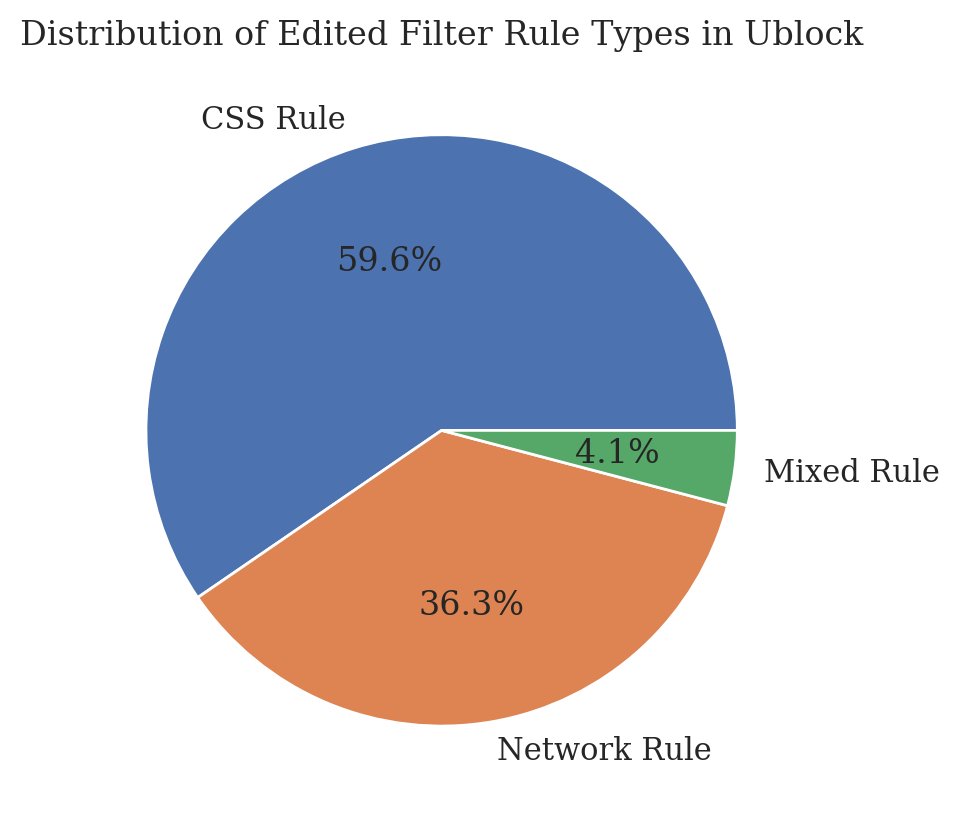

In [8]:
def stat():
    labels = pd.read_csv(UBLOCK_LIST_OUTPUT_DIR.joinpath("rule-types.csv"))
    # are ids unique
    print(f"Number of Unique IDs: {len(labels['id'].unique())}")
    print(f"Example of Duplicate IDs: {labels[labels['id'].duplicated()]}")
    
    correct_labels = labels[(labels['rule'] == RuleType.NETWORK) | (labels['rule'] == RuleType.CSS) | (labels['rule'] == "XXX")]
    print(f"Number of Correctly Labeled Rules: {len(correct_labels)}")
    print(f"Number of Unlabeled Rules: {len(labels) - len(correct_labels)}")
    print(f"Number of CSS Rules: {len(correct_labels[correct_labels['rule'] == RuleType.CSS])}")
    print(f"Number of Network Rules: {len(correct_labels[correct_labels['rule'] == RuleType.NETWORK])}")
    
    p = correct_labels['rule'].value_counts()
    
    keys = {
        RuleType.CSS: "CSS Rule",
        RuleType.NETWORK: "Network Rule",
        "XXX": "Mixed Rule"
    }
    
    plt.pie(p.values, labels=[keys[a] for a in p.keys()], autopct='%1.1f%%')
    plt.title("Distribution of Edited Filter Rule Types in Ublock")
stat()

You can either generate the `manual-reproduce.csv` by checking if issues are reproducible or use a pre-ignored list of issue ids by running the function below

In [10]:
def generate_reproducibility_from_ignore():
    df = pd.read_csv(UBLOCK_LIST_OUTPUT_DIR.joinpath("ublock-data.csv"))

    with open(UBLOCK_INPUT_DIR.joinpath("data/ignore.txt"), 'r') as f: 
        ignore_list = [int(x) for x in f.read().split("\n")]
        
    df_failed  = df[df['id'].isin(ignore_list)]
    df_failed[['id', 'title', 'test_url' , 'issue_url']].to_csv(UBLOCK_LIST_OUTPUT_DIR.joinpath("failed-ublock-data.csv"))

    df_reproduce = df.copy()[['id']]
    df_reproduce['reproduce'] = ~((df['label'] == 'D') | (df['label'] == 'S'))
    df_reproduce.to_csv(UBLOCK_LIST_OUTPUT_DIR.joinpath("manual-reproduce.csv"), index=False)
    
generate_reproducibility_from_ignore()

Total labeled: 638
Total Reproducible: 203 (32%)
Total unique reproducing problems: 7
	 Most occuring problem: page not accessible (13)
	 Least occuring problem: no fix (1)
Total dynamic posts: 193 (44%)


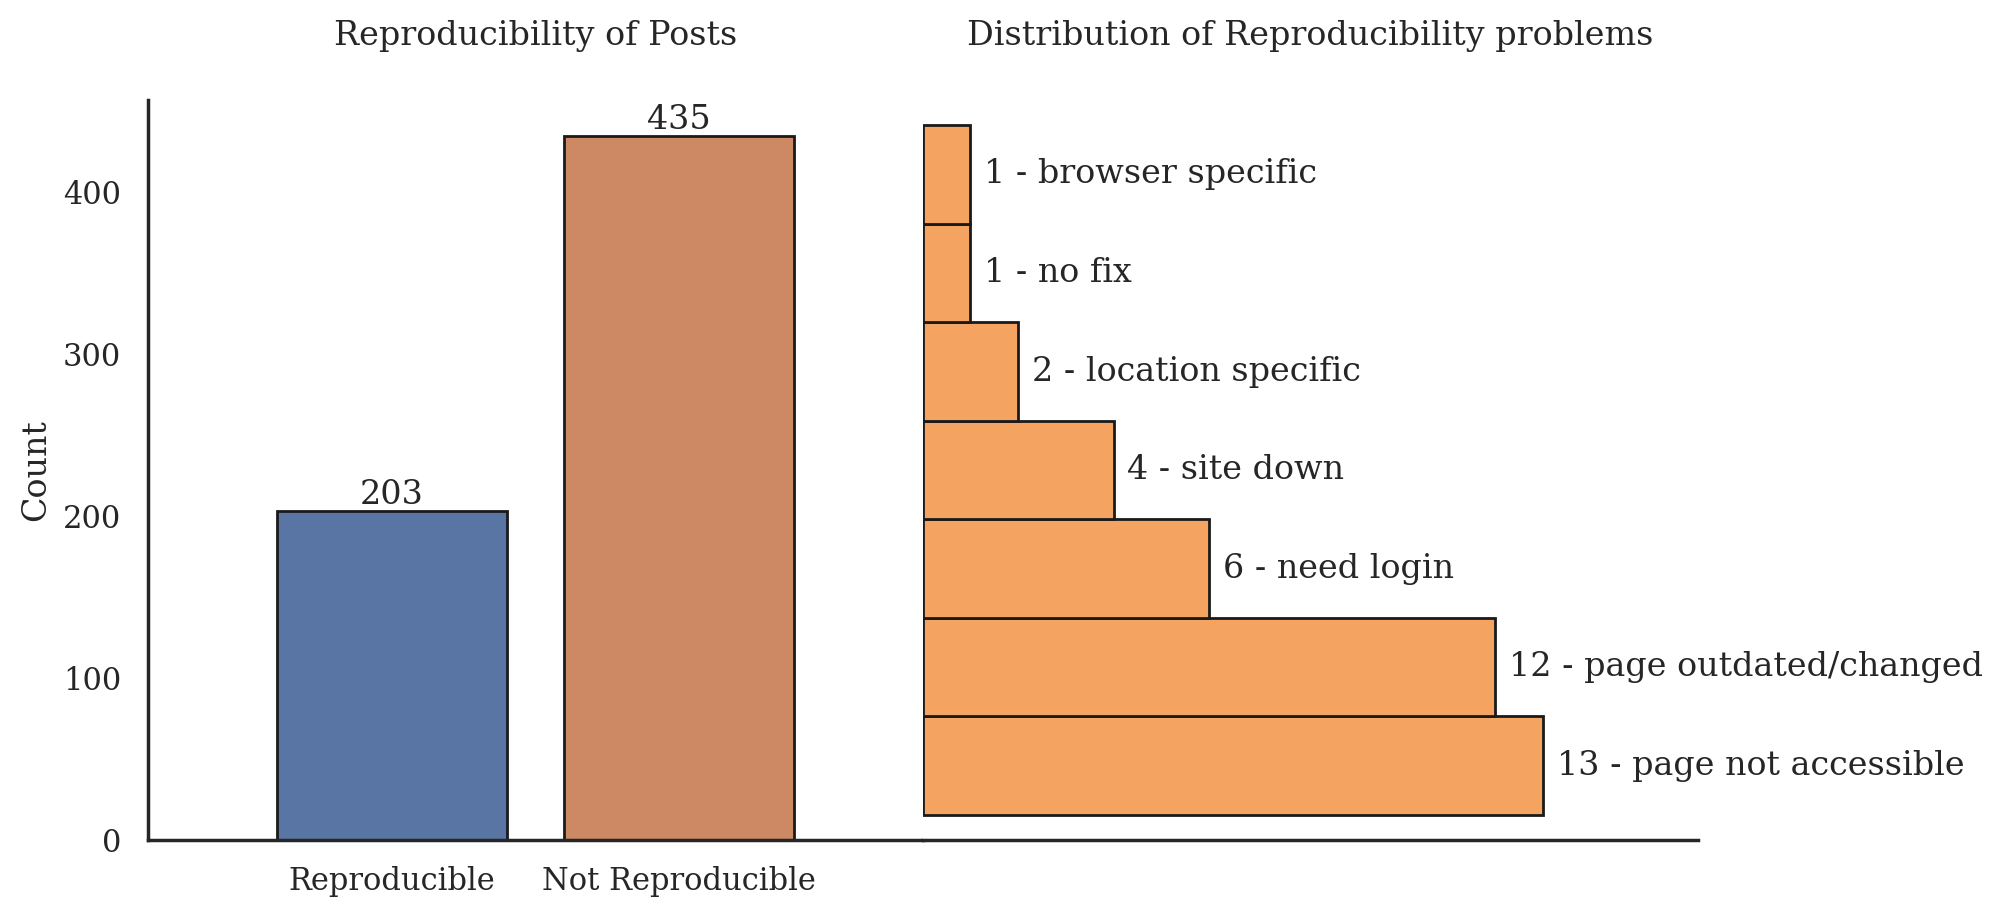

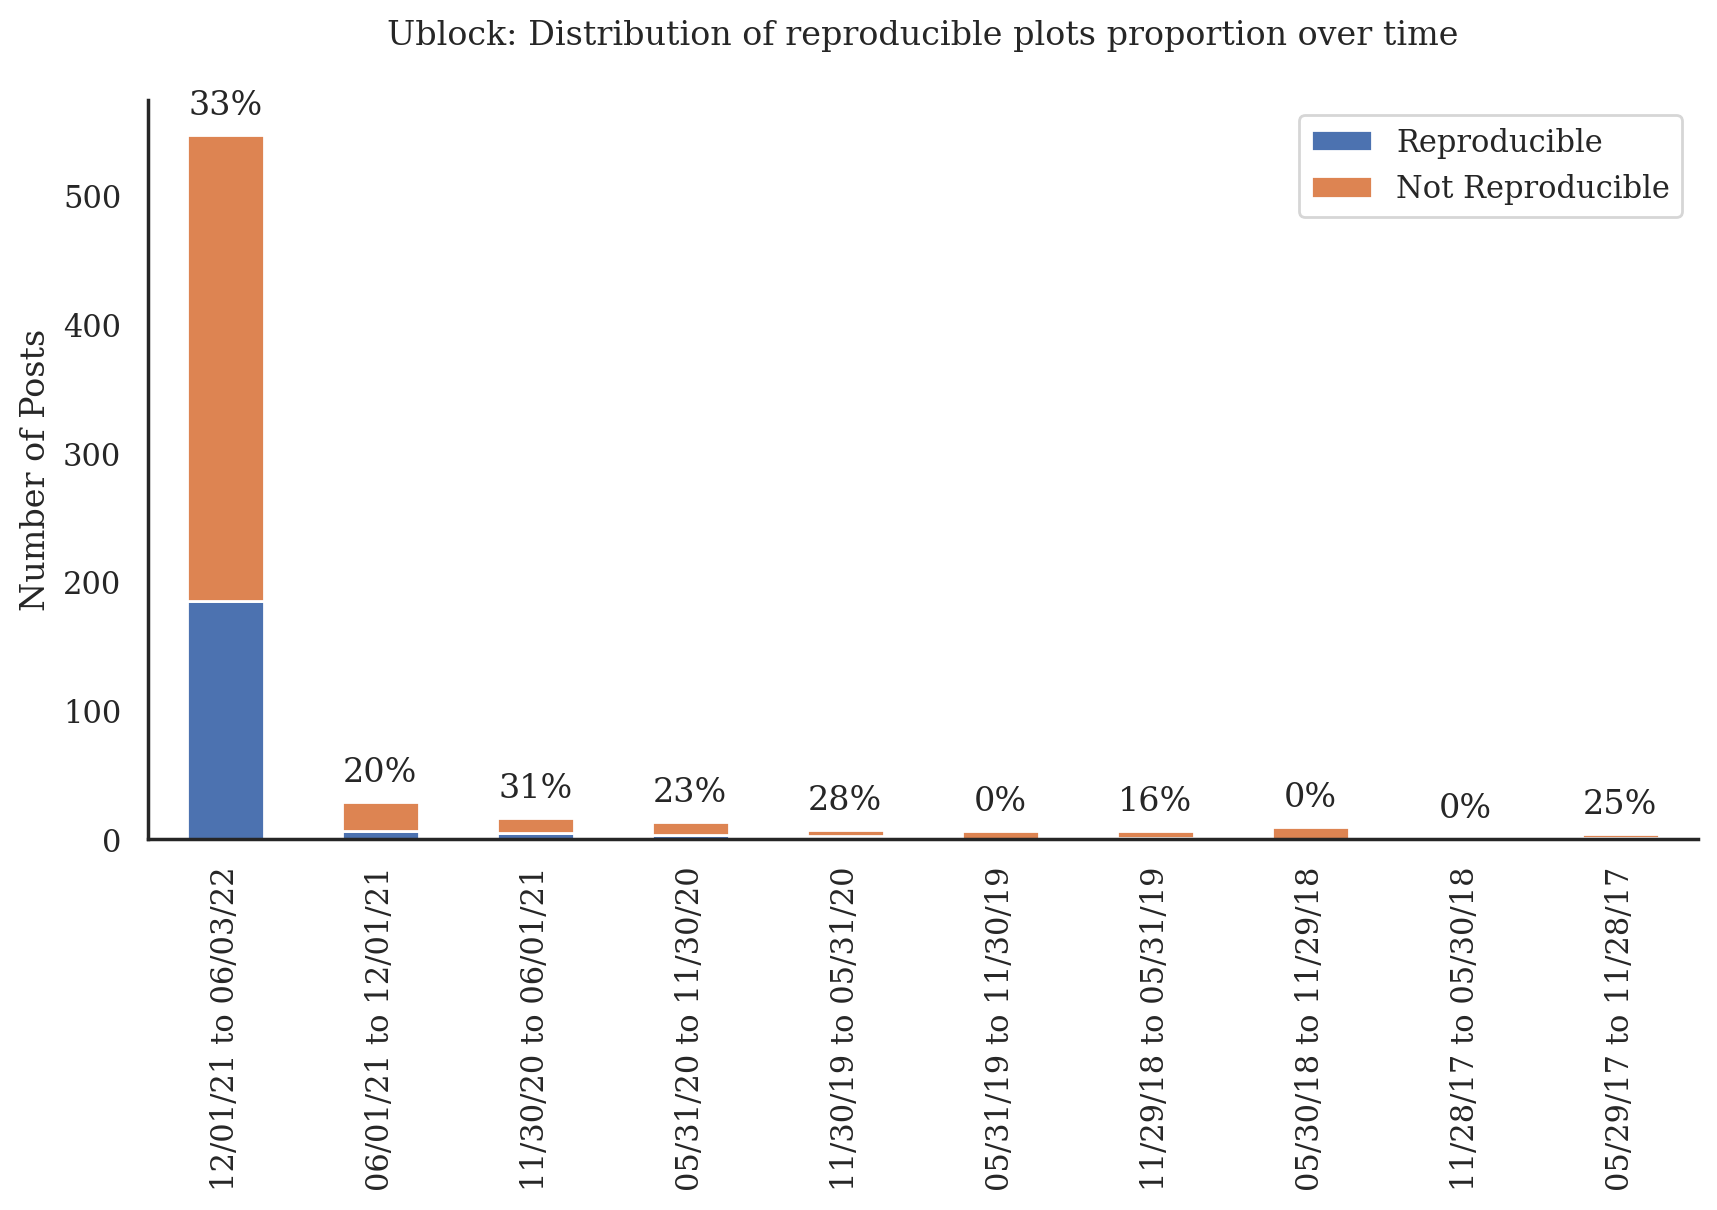

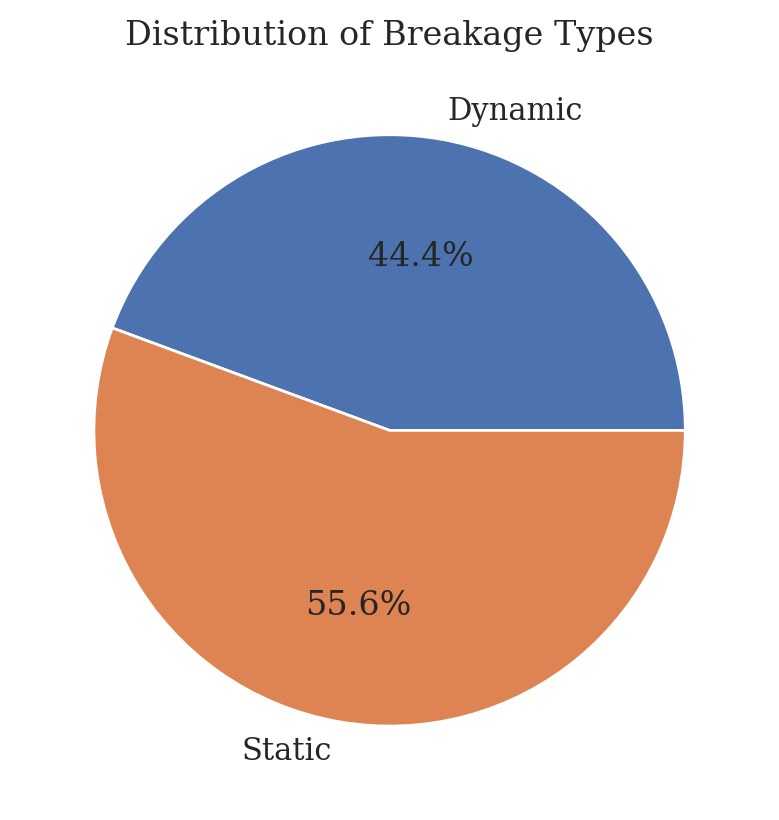

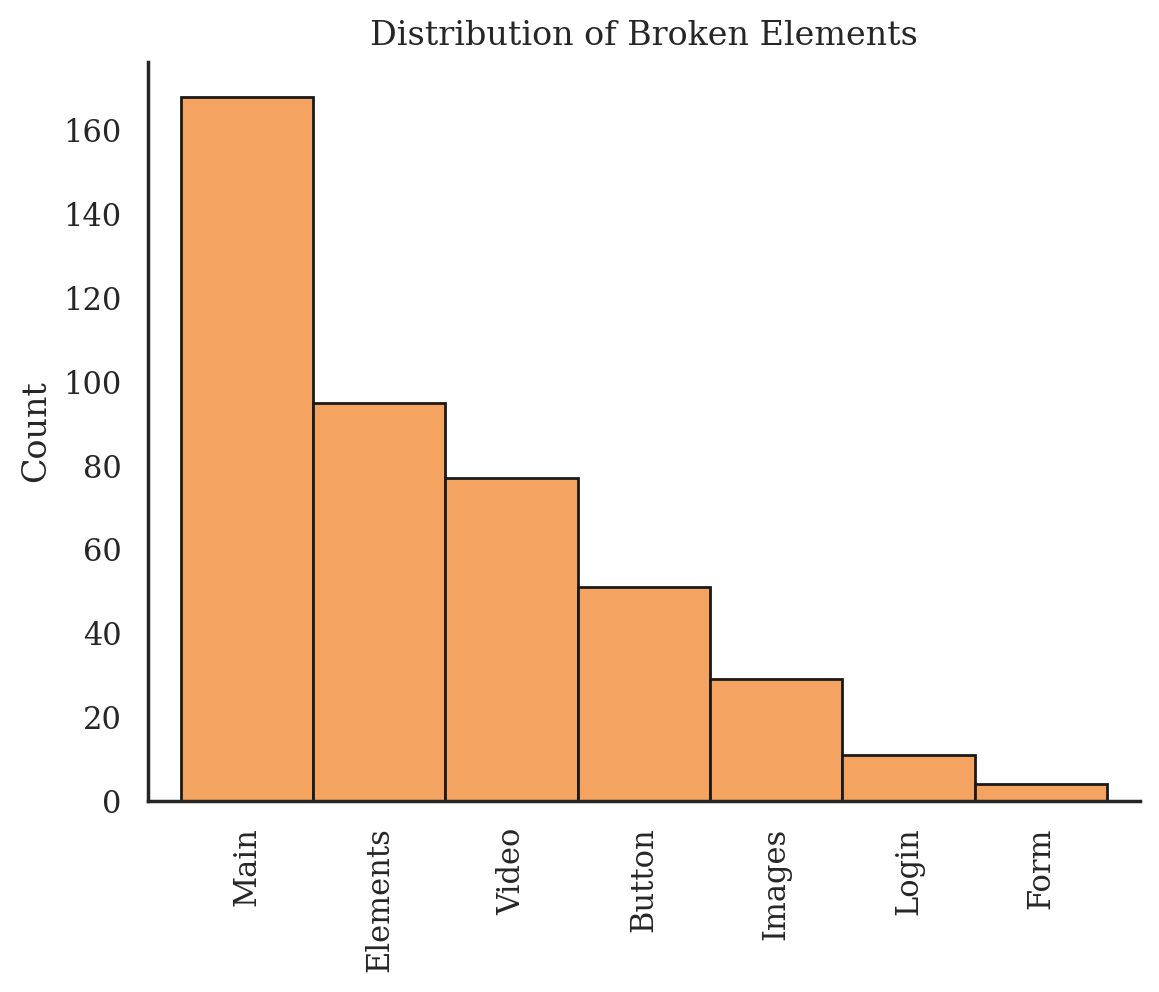

In [27]:
# stats on the dataset

def stats():
    df = pd.read_csv(UBLOCK_LIST_OUTPUT_DIR.joinpath("ublock-data.csv"))
    df_co = pd.read_csv(UBLOCK_LIST_OUTPUT_DIR.joinpath("manual-comment.csv")).dropna().astype({'id': 'int64'})
    df_re = pd.read_csv(UBLOCK_LIST_OUTPUT_DIR.joinpath("manual-reproduce.csv")).dropna().astype({'id': 'int64'})
    df_bt = pd.DataFrame({
        'id': df['id'],
        'breakage-type': df['label'],
    })
    
    df_el = pd.DataFrame({
        'id': df[(df['label'] == 'D')|(df['label'] == 'S')]['id'],
        'element': df[(df['label'] == 'D')|(df['label'] == 'S')]['category'],
    })

    total = len(df_re)
    print(f"Total labeled: {total}")

    # reproducibility
    
    num_rep = len(df_re[df_re['reproduce']])
    print(f"Total Reproducible: {num_rep} ({round(num_rep/total * 100)}%)")
    
    fig, axes = plt.subplots(1, 2, squeeze=True, )
    plt.subplots_adjust(wspace=0, hspace=0)
    fig.set_figwidth(10)
    
    ax = sns.barplot(x=['Reproducible', 'Not Reproducible'], y=[num_rep, total-num_rep], ax = axes[0], edgecolor='k')
    ax.margins(x=0.25)
    sns.despine(ax=ax, right=True)
    axes[0].set_ylabel("Count")
    for container in ax.containers:
        ax.bar_label(container)
        
    axes[0].set_title("Reproducibility of Posts", pad=20)
    
    
    df_re_co = df_re[df_re['reproduce'] == False].merge(df_co, on='id')
    
    rep_probs = df_re_co['comment'].value_counts()
    print(f"Total unique reproducing problems: {len(rep_probs)}")
    print(f"\t Most occuring problem: {rep_probs.index[rep_probs.argmax()]} ({rep_probs.max()})")
    print(f"\t Least occuring problem: {rep_probs.index[rep_probs.argmin()]} ({rep_probs.min()})")
    
    ax = df_re_co['comment'].value_counts().plot.barh(ax=axes[1], edgecolor='k', width=1, color='sandybrown')
    for container in ax.containers:
        ax.bar_label(container, padding=5, labels = [f"{rep_probs[r]} - {r}" for r in rep_probs.index])
    ax.margins(x=0.25, y=10)
    sns.despine(ax=ax, left=True, right=True)
    ax.set(xticklabels=[], yticklabels=[])
    
    
    axes[1].set_title("Distribution of Reproducibility problems", pad=20)
    
    
    # reproducibility over time
    
    fig, ax = plt.subplots()
    
    fig.set_figwidth(10)
    df_re_time = df_re.merge(df, on='id')[['reproduce', 'created_at']]
    
    datetimes_all = df_re_time['created_at'].apply(lambda row: datetime.strptime(row.split("T")[0], "%Y-%m-%d").timestamp()).values
    datetimes_true = df_re_time[df_re_time['reproduce']]['created_at'].apply(lambda row: datetime.strptime(row.split("T")[0], "%Y-%m-%d").timestamp()).values
    
    bins = 10
    y_all, x_all = np.histogram(datetimes_all, bins=bins)
    y_true, _ = np.histogram(datetimes_true, bins=bins, range=(min(datetimes_all), max(datetimes_all)))
    
    y_not = [y_all[i] - y_true[i] for i in range(len(y_all))]
    
    x = [ f"{datetime.fromtimestamp(x_all[i]).strftime('%D')} to {datetime.fromtimestamp(x_all[i+1]).strftime('%D')}"  for i in range(len(x_all)-1)]
    labels =[f"{int(y_true[i]/y_all[i] * 100) if y_all[i] != 0 else 0}%" for i in range(len(y_all))]
    
    y_true = y_true[::-1]
    y_not = y_not[::-1]
    x = x[::-1]
    labels=labels[::-1]
    
    df_time = pd.DataFrame(
        {
            'Reproducible': y_true,
            'Not Reproducible': y_not,            
        },
        index = x
    )
    
    df_time.plot(kind='bar', stacked=True, ax=ax, legend=True)
    plt.legend()
    plt.title("Ublock: Distribution of reproducible plots proportion over time", pad=20)
    plt.ylabel("Number of Posts")
    ax.set(xticklabels=x)
    ax.tick_params(axis='x', rotation=90)
    
    ax.bar_label(ax.containers[1], padding=5, labels = labels)

    # ax.axvline(20, color='sandybrown', linestyle='dashed')
    sns.despine(ax=ax, left=False, right=True)
    
    # breakage type
    total_dynamic = len(df_bt[df_bt['breakage-type']=='D'])
    total_static = len(df_bt[df_bt['breakage-type']=='S'])
    
    print(f"Total dynamic posts: {total_dynamic} ({round(total_dynamic/(total_dynamic + total_static) *100)}%)")
    
    fig, ax = plt.subplots()
    
    
    plt.pie([total_dynamic,total_static],labels=['Dynamic', 'Static'], autopct='%1.1f%%')
    plt.title("Distribution of Breakage Types")
    
    fig, ax = plt.subplots()
    
    ax = df_el['element'].value_counts().plot.bar(edgecolor='k', width=1, color='sandybrown')
    
    sns.despine(ax=ax, left=False, right=True)
    plt.ylabel("Count")
    plt.title("Distribution of Broken Elements")
    
    
    
stats()


Combining the manual features to the dataset

In [ ]:
def update_manual_labels(): 
    df = pd.read_csv(UBLOCK_LIST_OUTPUT_DIR.joinpath("ublock-data.csv")).dropna().astype({'id': 'int64'})
    df_rt = pd.read_csv(UBLOCK_LIST_OUTPUT_DIR.joinpath("rule-types.csv")).dropna().astype({'id': 'int64'})
    
    for _, row in df.iterrows():
        if isinstance(row.test_url, str) and len(row.test_url) > 1 and "://" not in row.test_url:
            df.loc[df['id'] == row.id, 'test_url'] = "https://"+row.test_url
        
    if "rule_type" not in df.columns:
        df = df.merge(df_rt, on='id', how='outer')
    
    df = df.drop(columns = [c for c in df.columns if 'unnamed' in c or 'Unnamed' in c])
    
    df = df.rename(columns = {
        'rule': 'rule_type',
        
    })
    
    df.to_csv(UBLOCK_LIST_OUTPUT_DIR.joinpath("ublock-data.csv"))
    
update_manual_labels()

### Additional Statistics


#### statistics on the number of posts with test URLs different from the domain URLs

In [7]:
def stats():
    df = pd.read_csv(UBLOCK_LIST_OUTPUT_DIR.joinpath("ublock-data.csv"))
    df = df[df.should_include == True]
    
    
    def url_in_title(title):
        urls = re.findall(pattern=URL_REGEX, string=title)
        
        for url in urls:
            
            # prevent instances where the issue url is mentioned
            if "github" not in url:
                return url
        
        return None
    
    def get_commit_title(repo, commit):
        req = f"https://api.github.com/repos/{repo}/commits/{commit}"
        resp = requests.get(req, headers=headers).json()
        
        return resp['commit']['message']
        
    
    uit = df.title.apply(lambda x: url_in_title(x))
    uic = df.progress_apply(lambda x: url_in_title(get_commit_title(x.repo, x.after_commit)), axis=1)
    
    print(f"The number of issues without a URL in the post title: {sum(uit.isna())}")
    print(f"The number of issues without a URL in the commit title: {sum(uic.isna())}")
    
    
    a = pd.DataFrame({
        'id': df['id'],
        'title_url': uit,
        'commit_url': uic,
        'test_url': df['test_url'],
    })
    
    a.to_csv(UBLOCK_LIST_OUTPUT_DIR.joinpath("url-stats.csv"))

stats()

100%|██████████| 355/355 [01:35<00:00,  3.71it/s]

The number of issues without a URL in the post title: 17
The number of issues without a URL in the commit title: 300


## Easylist

In [3]:
## CONFIG ##
# The output directory
EASY_LIST_OUTPUT_DIR = Path("./forums-out/easylist")

### Scraping
First, we need to scrape the issues list.
This creates an `issues.csv` file.

In [11]:
easylist.crawl_issues(
    out_dir = str(EASY_LIST_OUTPUT_DIR)
)

100%|██████████| 158/158 [01:51<00:00,  1.42it/s]


Number of Issues: 7900
Number of Locked Issues: 7660
Earliest Post: 2006-07-29
Latest Locked Post: 2023-01-27
Latest Post: 2023-05-18
Number of Issues in last 3 years: 1010
Number of Issues Locked in last 3 years: 898


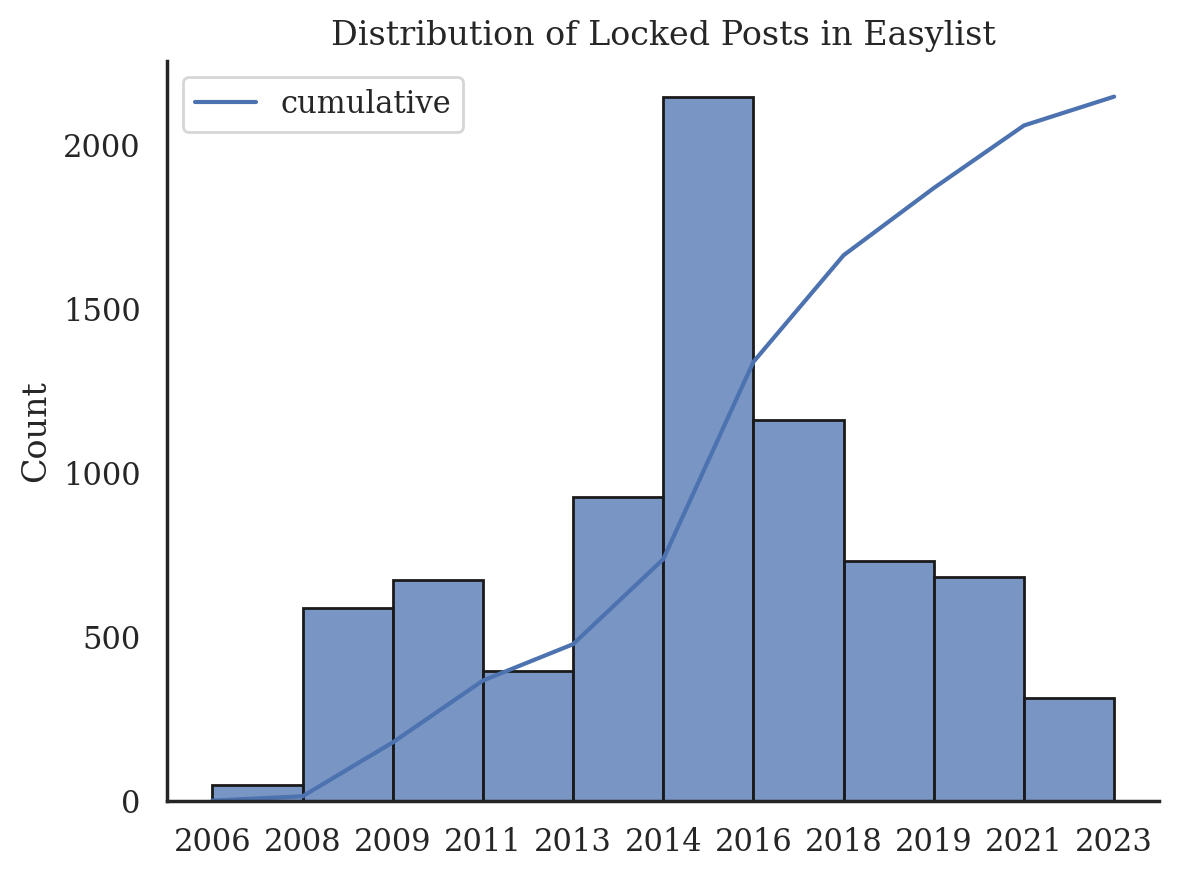

In [49]:
def stat():
    df = pd.read_csv(EASY_LIST_OUTPUT_DIR.joinpath("issues.csv"))
    
    print(f"Number of Issues: {len(df)}")
    print(f"Number of Locked Issues: {len(df[df['locked']])}")
    
    
    datetimes = df['created_at'].apply(lambda row: datetime.strptime(row.split("T")[0], "%Y-%m-%d").timestamp()).values
    datetimes_locked = df[df['locked']]['created_at'].apply(lambda row: datetime.strptime(row.split("T")[0], "%Y-%m-%d").timestamp()).values

    y,x  = np.histogram(datetimes_locked, bins=10)
    
    fig, ax = plt.subplots()
    ax  = sns.histplot(datetimes_locked, bins=10, edgecolor='k')
    
    s = [0]
    for yi in y:
        s.append(yi+s[-1])
    sns.lineplot(x= x, y=[p/max(s)*max(y) for p in s], label='cumulative')
    ax.xaxis.set_ticks(x)
    ax.set_title("Distribution of Locked Posts in Easylist")
    ax.set_xticklabels([datetime.fromtimestamp(t).date().year for t in x])
    
    #style_ax(ax)
    
    sns.despine(ax=ax, left=False, right=True)
    
    print(f"Earliest Post: {datetime.fromtimestamp(min(datetimes)).date()}")
    print(f"Latest Locked Post: {datetime.fromtimestamp(max(datetimes_locked)).date()}")
    print(f"Latest Post: {datetime.fromtimestamp(max(datetimes)).date()}")
    print(f"Number of Issues in last 3 years: {len(df[df['created_at'].apply(lambda row: datetime.strptime(row.split('T')[0], '%Y-%m-%d').year) >= 2020])}")
    print(f"Number of Issues Locked in last 3 years: {len(df[(df['created_at'].apply(lambda row: datetime.strptime(row.split('T')[0], '%Y-%m-%d').year) >= 2020) & (df['locked'])])}")
             
stat()

Second, we scrape each post for reproducing information. This will generate a `details.csv` and `investigate.csv` files. The latter contains issues that need manual investigation before adding them to included issues.

In [ ]:
easylist.crawl_details(
    list_fp= str(EASY_LIST_OUTPUT_DIR.joinpath("issues.csv").resolve()),
    #force=..., # to overwrite details.csv
    #date_threshold=... # crawl all posts later than this date
    #count_threshold=... # cap on the number of crawled posts
    #count_fixed_threshold=... # cap on the number of successful crawled posts
)

In [8]:
import importlib

importlib.reload(easylist)

<module 'BreakageClassifier.code.forums.easylist.builder' from '/home/saiid/summer22-SaiidHajj/Experiments/../BreakageClassifier/code/forums/easylist/builder.py'>

In [ ]:
easylist.get_num_commits(
    list_fp= str(EASY_LIST_OUTPUT_DIR.joinpath("issues.csv").resolve()),
)

In [21]:
# stats on number of commits
def stats():
    df = pd.read_csv(EASY_LIST_OUTPUT_DIR.joinpath("commits.csv"))
    df = df[df.n_commits != 0]
    
    counts = df.n_commits.value_counts()
    print(counts)
    
    n_one_commit = len(df[df.n_commits == 1])
    n_more_than_one = len(df[df.n_commits>1])
    
    print(f"Number of posts with one commit: {n_one_commit}")
    print(f"Number of posts with 2 commit or more: {n_more_than_one} ({int(n_more_than_one/(n_one_commit + n_more_than_one)*100)}%)")
    
    
    
stats()

1    1356
2     235
3      44
4      18
5       4
6       2
9       1
8       1
Name: n_commits, dtype: int64
Number of posts with one commit: 1356
Number of posts with 2 commit or more: 305 (18%)


Finally combine the dataset. This will generate the `easylist-data.csv` of interest.

In [ ]:
def stat():
    df = pd.read_csv(EASY_LIST_OUTPUT_DIR.joinpath("issues.csv"))
    
    print(f"Number of Issues: {len(df)}")
    print(f"Number of Locked Issues: {len(df[df['locked']])}")
    
    
    datetimes = df['created_at'].apply(lambda row: datetime.strptime(row.split("T")[0], "%Y-%m-%d").timestamp()).values
    datetimes_locked = df[df['locked']]['created_at'].apply(lambda row: datetime.strptime(row.split("T")[0], "%Y-%m-%d").timestamp()).values

    y,x  = np.histogram(datetimes_locked, bins=10)
    
    fig, ax = plt.subplots()
    ax  = sns.histplot(datetimes_locked, bins=10, edgecolor='k')
    
    s = [0]
    for yi in y:
        s.append(yi+s[-1])
    sns.lineplot(x= x, y=[p/max(s)*max(y) for p in s], label='cumulative')
    ax.xaxis.set_ticks(x)
    ax.set_title("Distribution of Locked Posts in Easylist")
    ax.set_xticklabels([datetime.fromtimestamp(t).date().year for t in x])
    
    #style_ax(ax)
    
    sns.despine(ax=ax, left=False, right=True)
    
    print(f"Earliest Post: {datetime.fromtimestamp(min(datetimes)).date()}")
    print(f"Latest Locked Post: {datetime.fromtimestamp(max(datetimes_locked)).date()}")
    print(f"Latest Post: {datetime.fromtimestamp(max(datetimes)).date()}")
    print(f"Number of Issues in last 3 years: {len(df[df['created_at'].apply(lambda row: datetime.strptime(row.split('T')[0], '%Y-%m-%d').year) >= 2020])}")
    print(f"Number of Issues Locked in last 3 years: {len(df[(df['created_at'].apply(lambda row: datetime.strptime(row.split('T')[0], '%Y-%m-%d').year) >= 2020) & (df['locked'])])}")
             
stat()

In [4]:
easylist.combine(
    issues_fp=EASY_LIST_OUTPUT_DIR.joinpath("issues.csv"),
    details_fp=EASY_LIST_OUTPUT_DIR.joinpath("details.csv"),
    out_fp=EASY_LIST_OUTPUT_DIR.joinpath("easylist-data.csv")
)

Number of posts: 7900
Number of fixed posts: 7635
Number of useful posts: 1344
Number of posts that need manual investigation: 3284


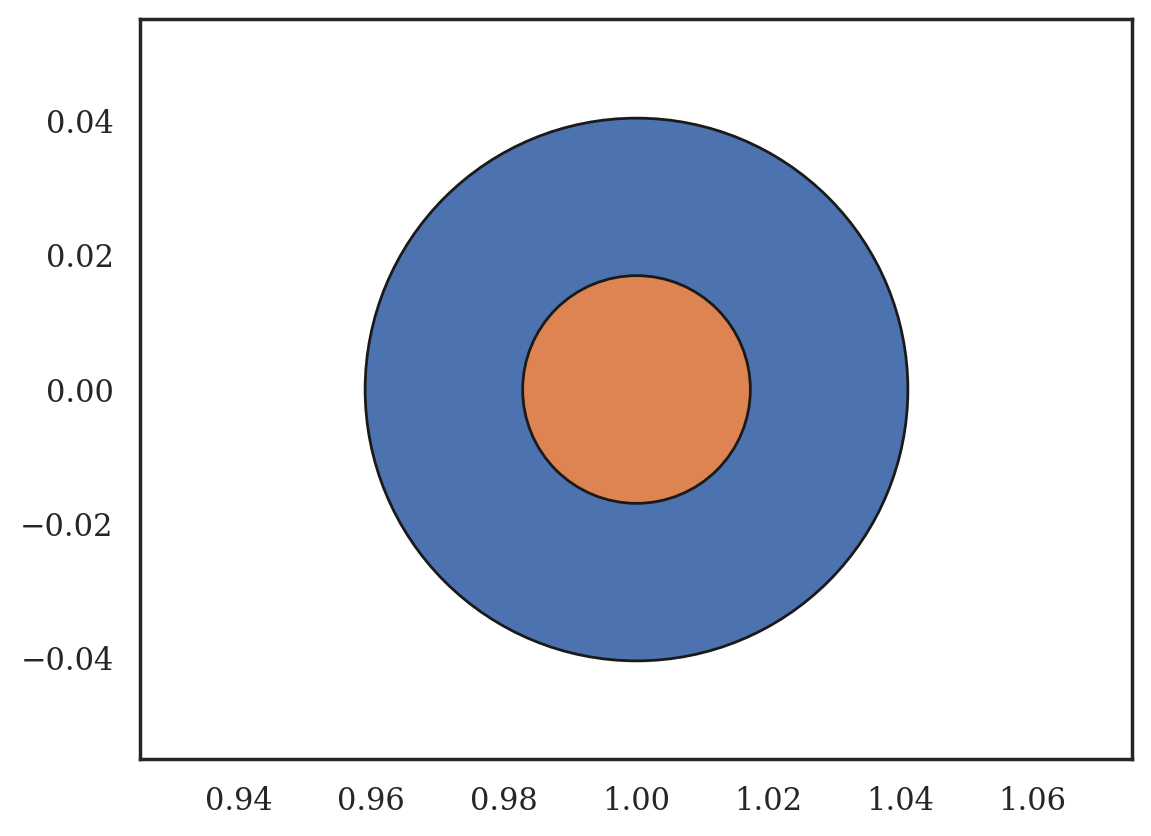

In [35]:
def stat():
    df = pd.read_csv(EASY_LIST_OUTPUT_DIR.joinpath("easylist-data.csv"))
    df2 = pd.read_csv(EASY_LIST_OUTPUT_DIR.joinpath("investigate.csv"))
    
    print(f"Number of posts: {len(df)}")
    print(f"Number of fixed posts: {len(df[df['fixed']])}")
    print(f"Number of useful posts: {len(df[df['should_include']])}")
    print(f"Number of posts that need manual investigation: {len(df2)}")
    
    
    #plt.pie([len(df), len(df[df['fixed']]), len(df[df['should_include']])],labels=['posts', 'fixed posts', 'posts with valid description'])
    fig, ax = plt.subplots()
    scale = 5
    plt.scatter([1], [0], s=[scale*len(df[df['fixed']])], edgecolors='k')
    plt.scatter([1], [0], s=[scale*len(df[df['should_include']])], edgecolors='k')
    plt.annotate("fixed posts", (0,0))
    ax.margins(x=0.25)
    
stat()

### Compiling filterlists
We need to download issues filterlists for crawling purposes later on

In [ ]:
generate_filterlists(
    issues_fp=EASY_LIST_OUTPUT_DIR.joinpath("issues.csv"),
    out_fp=EASY_LIST_OUTPUT_DIR,
    #force=...
)

### Manual Labeling
In this section, we can manually label the issues for the following attributes:
- Cause of breakage
    - Network Rule
    - CSS Rule
- Reproducibility
    - Reproducible
    - Not Reproducible
- Type of breakage
    - Static
    - Dynamic

In [ ]:
# preprocessing automated rule type detection
generate_rule_types_from_file(EASY_LIST_OUTPUT_DIR.joinpath("easylist-data.csv"))

Number of Correctly Labeled Rules: 1343
Number of Unlabeled Rules: 1
Number of CSS Rules: 428
Number of Network Rules: 836
Number of Mixed Rules: 79


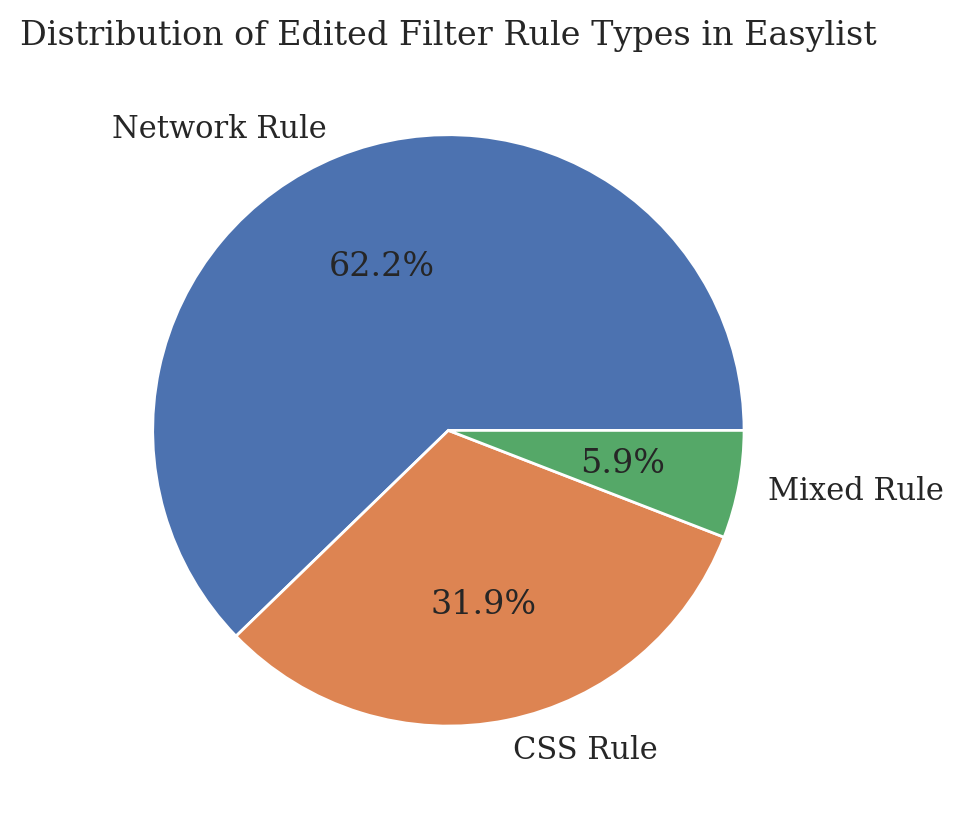

In [11]:
def stat():
    labels = pd.read_csv(EASY_LIST_OUTPUT_DIR.joinpath("rule-types.csv"))
    correct_labels = labels[(labels['rule'] == RuleType.NETWORK) | (labels['rule'] == RuleType.CSS) | (labels['rule'] == "XXX")]
    print(f"Number of Correctly Labeled Rules: {len(correct_labels)}")
    print(f"Number of Unlabeled Rules: {len(labels) - len(correct_labels)}")
    print(f"Number of CSS Rules: {len(correct_labels[correct_labels['rule'] == RuleType.CSS])}")
    print(f"Number of Network Rules: {len(correct_labels[correct_labels['rule'] == RuleType.NETWORK])}")
    print(f"Number of Mixed Rules: {len(correct_labels[correct_labels['rule'] == 'XXX'])}")
    p = correct_labels['rule'].value_counts()
    
    keys = {
        RuleType.CSS: "CSS Rule",
        RuleType.NETWORK: "Network Rule",
        "XXX": "Mixed Rule"
    }
    
    plt.pie(p.values, labels=[keys[a] for a in p.keys()], autopct='%1.1f%%')
    plt.title("Distribution of Edited Filter Rule Types in Easylist")
stat()

Total labeled: 170
Total Reproducible: 75 (44%)
Total unique reproducing problems: 11
	 Most occuring problem: page outdated/changed (45)
	 Least occuring problem: page detects adblocker (1)
Total dynamic posts: 19 (25%)


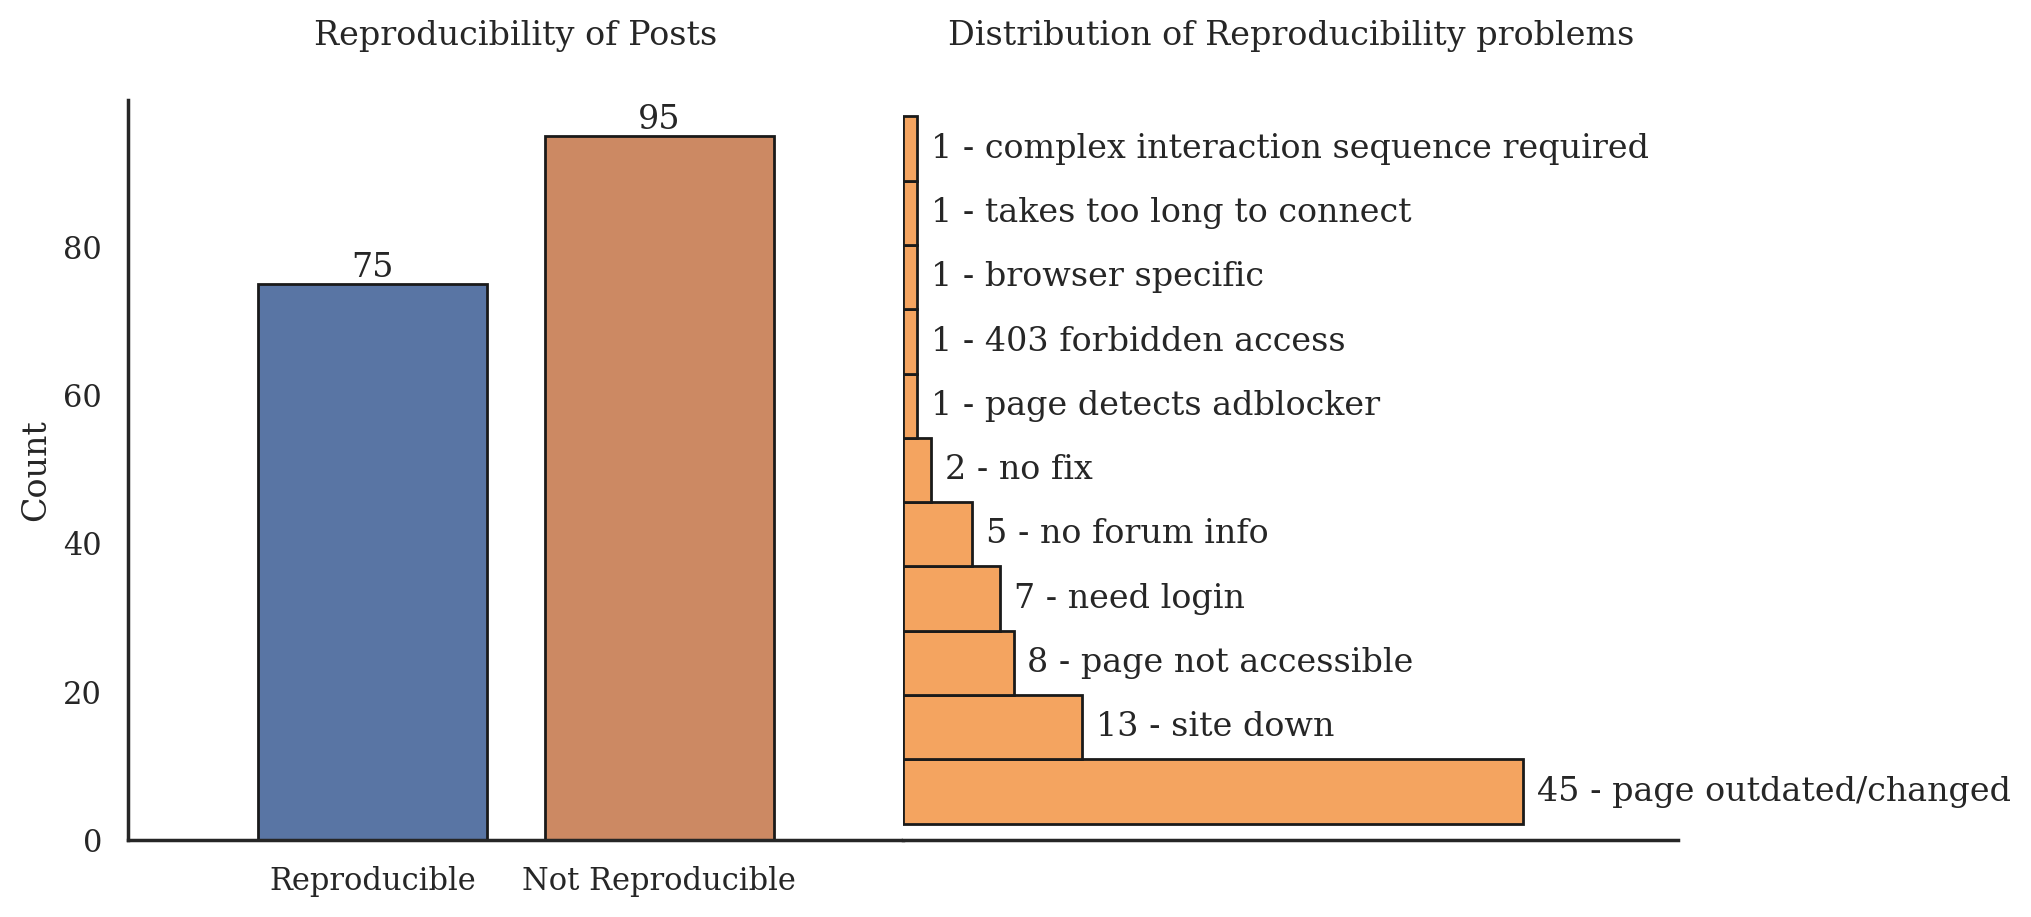

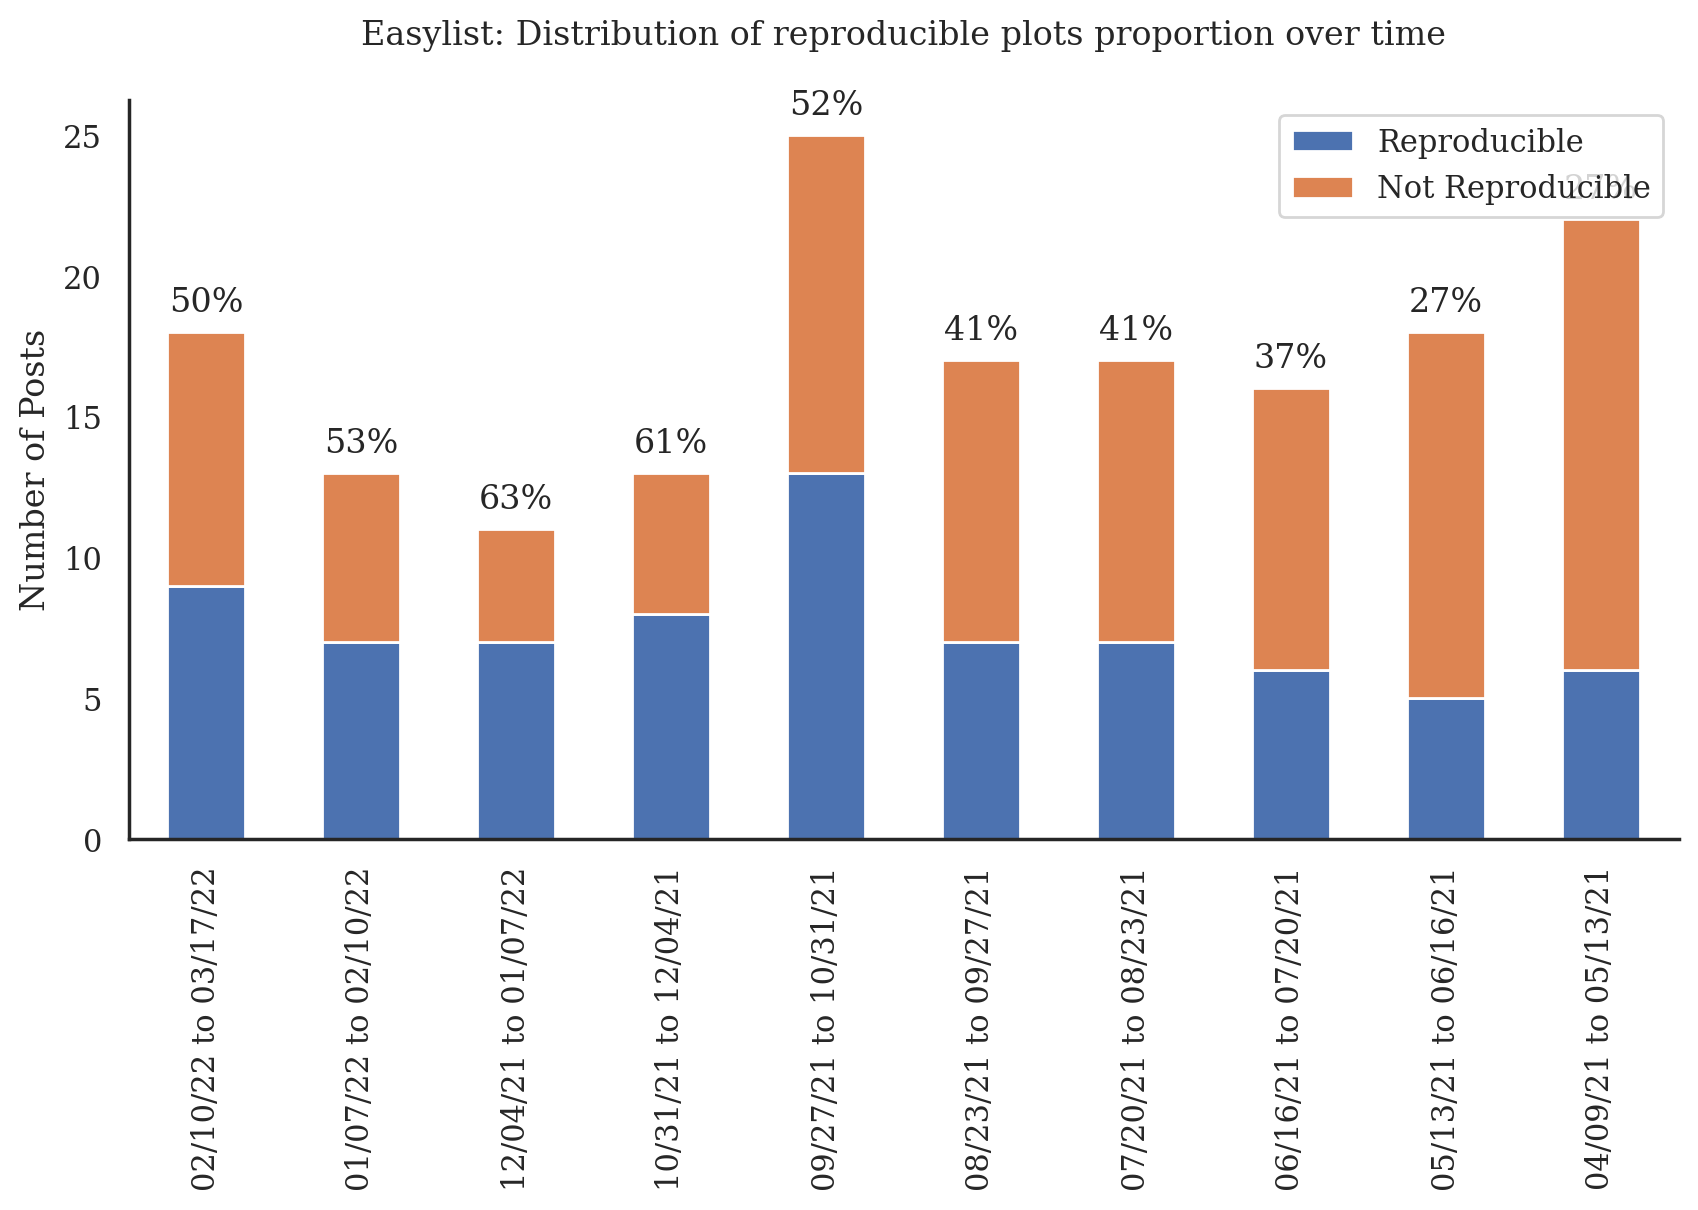

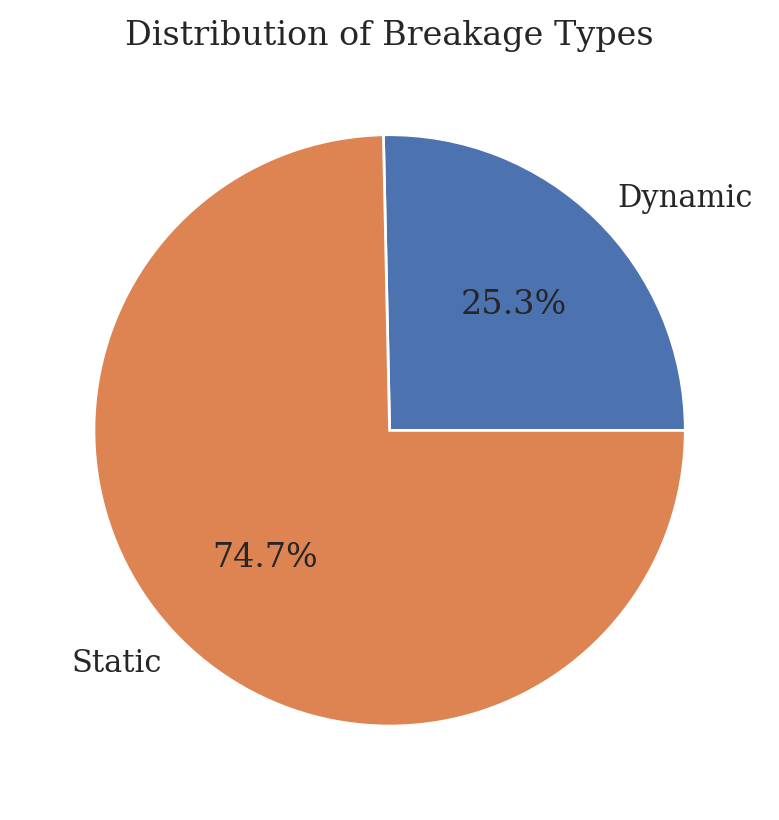

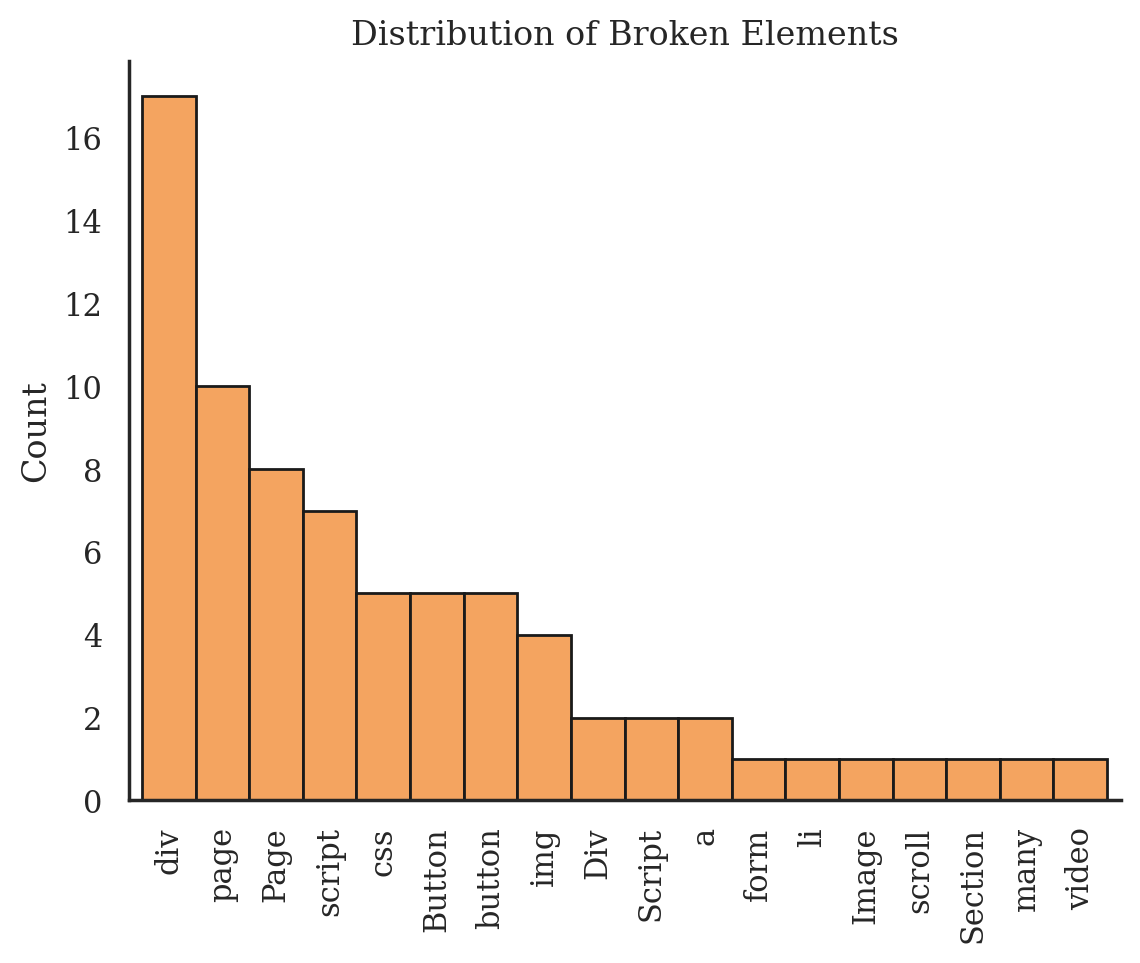

In [40]:
# stats on the dataset

def stats():
    df = pd.read_csv(EASY_LIST_OUTPUT_DIR.joinpath("easylist-data.csv"))
    df_bt = pd.read_csv(EASY_LIST_OUTPUT_DIR.joinpath("manual-breakage-type.csv")).dropna().astype({'id': 'int64'})
    df_co = pd.read_csv(EASY_LIST_OUTPUT_DIR.joinpath("manual-comment.csv")).dropna().astype({'id': 'int64'})
    df_el = pd.read_csv(EASY_LIST_OUTPUT_DIR.joinpath("manual-element.csv")).dropna().astype({'id': 'int64'})
    df_re = pd.read_csv(EASY_LIST_OUTPUT_DIR.joinpath("manual-reproduce.csv")).dropna().astype({'id': 'int64'})
    df_tu = pd.read_csv(EASY_LIST_OUTPUT_DIR.joinpath("manual-test-url.csv")).dropna().astype({'id': 'int64'})

    total = len(df_re)
    print(f"Total labeled: {total}")

    # reproducibility
    
    num_rep = len(df_re[df_re['reproduce']])
    print(f"Total Reproducible: {num_rep} ({round(num_rep/total * 100)}%)")
    
    fig, axes = plt.subplots(1, 2, squeeze=True, )
    plt.subplots_adjust(wspace=0, hspace=0)
    fig.set_figwidth(10)
    
    ax = sns.barplot(x=['Reproducible', 'Not Reproducible'], y=[num_rep, total-num_rep], ax = axes[0], edgecolor='k')
    ax.margins(x=0.25)
    sns.despine(ax=ax, right=True)
    axes[0].set_ylabel("Count")
    for container in ax.containers:
        ax.bar_label(container)
        
    axes[0].set_title("Reproducibility of Posts", pad=20)
    
    
    df_re_co = df_re[df_re['reproduce'] == False].merge(df_co, on='id')
    
    rep_probs = df_re_co['comment'].value_counts()
    print(f"Total unique reproducing problems: {len(rep_probs)}")
    print(f"\t Most occuring problem: {rep_probs.index[rep_probs.argmax()]} ({rep_probs.max()})")
    print(f"\t Least occuring problem: {rep_probs.index[rep_probs.argmin()]} ({rep_probs.min()})")
    
    ax = df_re_co['comment'].value_counts().plot.barh(ax=axes[1], edgecolor='k', width=1, color='sandybrown')
    for container in ax.containers:
        ax.bar_label(container, padding=5, labels = [f"{rep_probs[r]} - {r}" for r in rep_probs.index])
    ax.margins(x=0.25, y=10)
    sns.despine(ax=ax, left=True, right=True)
    ax.set(xticklabels=[], yticklabels=[])
    
    
    axes[1].set_title("Distribution of Reproducibility problems", pad=20)
    
    
    
    # reproducibility over time
    
    fig, ax = plt.subplots()
    
    fig.set_figwidth(10)
    
    df_re_time = df_re.merge(df, on='id')[['reproduce', 'created_at']]
    datetimes_all = df_re_time['created_at'].apply(lambda row: datetime.strptime(row.split("T")[0], "%Y-%m-%d").timestamp()).values
    datetimes_true = df_re_time[df_re_time['reproduce']]['created_at'].apply(lambda row: datetime.strptime(row.split("T")[0], "%Y-%m-%d").timestamp()).values
    
    
    bins = 10
    y_all, x_all = np.histogram(datetimes_all, bins=bins)
    y_true, _ = np.histogram(datetimes_true, bins=bins, range=(min(datetimes_all), max(datetimes_all)))
    
    y_not = [y_all[i] - y_true[i] for i in range(len(y_all))]
    x = [ f"{datetime.fromtimestamp(x_all[i]).strftime('%D')} to {datetime.fromtimestamp(x_all[i+1]).strftime('%D')}"  for i in range(len(x_all)-1)]
    labels =[f"{int(y_true[i]/y_all[i] * 100)}%" for i in range(len(y_all))]
    
    y_true = y_true[::-1]
    y_not = y_not[::-1]
    x = x[::-1]
    labels=labels[::-1]
    
    df_time = pd.DataFrame(
        {
            'Reproducible': y_true,
            'Not Reproducible': y_not,            
        },
        index = x
    )
    
    df_time.plot(kind='bar', stacked=True, ax=ax, legend=True)
    plt.legend()
    plt.title("Easylist: Distribution of reproducible plots proportion over time", pad=20)
    plt.ylabel("Number of Posts")
    ax.set(xticklabels=x)
    ax.tick_params(axis='x', rotation=90)
    
    ax.bar_label(ax.containers[1], padding=5, labels = labels)
    
    sns.despine(ax=ax, left=False, right=True)
    
    # breakage type
    total_dynamic = len(df_bt[df_bt['breakage-type']=='D'])
    
    print(f"Total dynamic posts: {total_dynamic} ({round(total_dynamic/num_rep *100)}%)")
    
    fig, ax = plt.subplots()
    
    
    plt.pie([total_dynamic,num_rep-total_dynamic],labels=['Dynamic', 'Static'], autopct='%1.1f%%')
    plt.title("Distribution of Breakage Types")
    
    fig, ax = plt.subplots()
    
    ax = df_el['element'].value_counts().plot.bar(edgecolor='k', width=1, color='sandybrown')
    
    sns.despine(ax=ax, left=False, right=True)
    plt.ylabel("Count")
    plt.title("Distribution of Broken Elements")
    
    
    
stats()


Now we add the manual elements to the dataset
- label: the breakage type: "D" or "S" or empty
- category: the element broken
- rule_type: whether 'CSS' or 'NET' or 'XXX' for both or 'ERR'

In [ ]:
def update_manual_labels(): 
    df = pd.read_csv(EASY_LIST_OUTPUT_DIR.joinpath("easylist-data.csv"))
    df_tu = pd.read_csv(EASY_LIST_OUTPUT_DIR.joinpath("manual-test-url.csv")).dropna().astype({'id': 'int64'})
    df_el = pd.read_csv(EASY_LIST_OUTPUT_DIR.joinpath("manual-element.csv")).dropna().astype({'id': 'int64'})
    df_bt = pd.read_csv(EASY_LIST_OUTPUT_DIR.joinpath("manual-breakage-type.csv")).dropna().astype({'id': 'int64'})
    df_rt = pd.read_csv(EASY_LIST_OUTPUT_DIR.joinpath("rule-types.csv"))
    
    for _, row in df_tu.iterrows():
        df.loc[df['id'] == row.id, 'test_url'] = row.test_url
        
    for _, row in df.iterrows():
        if isinstance(row.test_url, str) and len(row.test_url) > 1 and "://" not in row.test_url:
            df.loc[df['id'] == row.id, 'test_url'] = "https://"+row.test_url
            
    if "category" not in df.columns:
        df = df.merge(df_el, on='id', how='outer')
        
    if "label" not in df.columns:
        df = df.merge(df_bt, on='id', how= 'outer')
        
    if "rule_type" not in df.columns:
        df = df.merge(df_rt, on='id', how='outer')
    
    df = df.drop(columns = [c for c in df.columns if 'unnamed' in c or 'Unnamed' in c])
    
    df = df.rename(columns = {
        'breakage-type': 'label',
        'element': 'category',
        'rule': 'rule_type',
        
    })
    
    df.to_csv(EASY_LIST_OUTPUT_DIR.joinpath("easylist-data.csv"))
    
update_manual_labels()

### Additional Stats

In [8]:
def stats():
    df = pd.read_csv(EASY_LIST_OUTPUT_DIR.joinpath("easylist-data.csv"))
    df = df[df.should_include == True]
    
    def url_in_title(title):
        urls = re.findall(pattern=URL_REGEX, string=title)
        
        for url in urls:
            
            # prevent instances where the issue url is mentioned
            if "github" not in url and "forums.lanik" not in url:
                return url
        
        return None
    
    def get_commit_title(repo, commit):
        req = f"https://api.github.com/repos/{repo}/commits/{commit}"
        resp = requests.get(req, headers=headers).json()
        
        return resp['commit']['message']
        
    
    uit = df.title.apply(lambda x: url_in_title(x))
    uic = df.progress_apply(lambda x: url_in_title(get_commit_title(x.repo, x.after_commit)), axis=1)
    
    print(f"The number of issues without a URL in the post title: {sum(uit.isna())}")
    print(f"The number of issues without a URL in the commit title: {sum(uic.isna())}")
    
    
    a = pd.DataFrame({
        'id': df['id'],
        'title_url': uit,
        'commit_url': uic,
        'test_url': df['test_url'],
    })
    
    a.to_csv(EASY_LIST_OUTPUT_DIR.joinpath("url-stats.csv"))

stats()

100%|██████████| 1344/1344 [05:40<00:00,  3.95it/s]

The number of issues without a URL in the post title: 54
The number of issues without a URL in the commit title: 293


In [ ]:
# ['2006', '2007', '2008', '2009', '2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018', '2019', '2020', '2021', '2022', '2023']
# [0.0,     0.0,    0.0,    0.0,    0.0,    0.0,   0.0,     0.2,    0.5,    0.6,    17.8,   35.6,   42.8,   49.0,   60.4,   55.5,   17.5,   0.0]

## Website Categories (Webshrinker)
In this section, we extract the website type from the sites we plan to crawl.
After trying multiple approaches, the service fails to categorize specific pages in the site. So we have to restrict our analysis to the base domain.

In [9]:
import tldextract

tldextract.extract("https://www.aliexpress.edu.lb/item/4001049172728.html")

ExtractResult(subdomain='www', domain='aliexpress', suffix='edu.lb')

In [11]:
import requests
import validators
from base64 import urlsafe_b64encode
import csv
import tldextract


WEBSHRINKER_OUTPUT_DIR = Path("forums-out/webshrinker")

def extract_website_category(forum: str, issue_id, url: str) -> str:
    
    try:
        # make alot of assertions before the request because we are limited in the number of requests
        assert "WEBSHRINKER_API_KEY" in os.environ and "WEBSHRINKER_API_SECRET" in os.environ, "WEBSHRINKER_API_KEY and WEBSHRINKER_API_SECRET not defined in .env"
        assert url is not None and isinstance(url, str) and len(url) != 0, "url is not a string" 
        url_val = validators.url(url)
        assert url_val, f"'{url}' is not a valid url, {url_val}"
        
        extract = tldextract.extract(url)
        if len(extract.subdomain):
            top_level_url = f"https://{extract.subdomain}.{extract.domain}.{extract.suffix}"
        else:
            top_level_url = f"https://{extract.domain}.{extract.suffix}"
            
        
        url_bytes = top_level_url.encode()
        api_url = "https://api.webshrinker.com/categories/v3/%s" % urlsafe_b64encode(url_bytes).decode('utf-8')
        
        response = requests.get(api_url, auth=(os.environ.get("WEBSHRINKER_API_KEY"), os.environ.get("WEBSHRINKER_API_SECRET")))
        status_code = response.status_code
        data = response.json()
        
        category_rows = []
        is_live = False
        error = None
        
        if status_code == 200:
            
            category_data = data['data'][0]['categories']
            
            category_rows = [
                {
                    'forum': forum,
                    'issue': issue_id,
                    'url': url,
                    'cid': entry['id'],
                    'clabel': entry['label'],
                    'cscore': entry['score'],
                    'cconf': entry['confident']
                }
                for entry in category_data
            ]
        
        elif status_code == 202:
            is_live = True
            
        else:
            error = f"[{status_code}]"
            
            if 'error' in data:
                error += data['error']['message']
                
        return category_rows, is_live, error
    
    except Exception as e:
        return [], None, f"Runtime Error: {str(e)}"


In [ ]:
prev_session = None # change if you want to load sites from previous session


ublock_sites = pd.read_csv(UBLOCK_LIST_OUTPUT_DIR.joinpath("ublock-data.csv"))
ublock_sites = ublock_sites[(ublock_sites.label == 'D') | (ublock_sites.label == 'S')][['id', 'test_url']]

easylist_sites = pd.read_csv(EASY_LIST_OUTPUT_DIR.joinpath("easylist-data.csv"))
easylist_sites = easylist_sites[(easylist_sites.label == 'D') | (easylist_sites.label == 'S')][['id', 'test_url']]

print(f"{len(ublock_sites)+len(easylist_sites)} sites to categorise:")
print(f"ublock - {len(ublock_sites)}")
print(f"easylist - {len(easylist_sites)}", "\n")

webshrinker_session = f"webshrinker-categories-{datetime.now().timestamp() // 1}"
prev_df = None

if prev_session:
    try:
        prev_df = pd.read_csv(WEBSHRINKER_OUTPUT_DIR.joinpath(prev_session+".csv"))
        print("loaded previous session")
        
    except Exception as e:
        print("failed to load previous session")
        print(e)
        

with open(WEBSHRINKER_OUTPUT_DIR.joinpath(webshrinker_session+".csv"), newline='', mode='w') as csvfile:
    
    fieldnames = ['forum', 'issue', 'url', 'cid', 'clabel', 'cscore', 'cconf', 'is_live', 'error']
    writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
    
    writer.writeheader()
    
    for forum, dataset in [('ublock', ublock_sites), ('easylist', easylist_sites)]:
        for _, site in dataset.iterrows():
            
            # check prev
            if prev_df is not None:
                entries = prev_df[(prev_df['forum'] == forum) & (prev_df['issue'] == site.id)]
                if len(entries) > 0 and isinstance(entries.iloc[0].cid, str):
                    print(f"{forum}/{site.id} [{site.test_url}]: Found in previous session")
                    for _, entry in entries.iterrows():
                        writer.writerow(
                            {
                                'forum': entry.forum,
                                'issue': entry.issue,
                                'url': entry.url,
                                'cid': entry.cid,
                                'clabel': entry.clabel,
                                'cscore': entry.cscore,
                                'cconf': entry.cconf,
                                'is_live': False,
                                'error': None
                            }
                        )
                    continue
        
            data, is_live, error = extract_website_category (forum, site.id, site.test_url)
            
            if error:
                print(f"ERROR for {forum}/{site.id} [{site.test_url}]: {error}")
                writer.writerow(
                            {
                                'forum': forum,
                                'issue': site.id,
                                'url': site.test_url,
                                'cid': None,
                                'clabel': None,
                                'cscore': None,
                                'cconf': None,
                                'is_live': False,
                                'error': error
                            }
                        )
                
            elif is_live:
                print(f"{forum}/{site.id} [{site.test_url}]: Site category not yet determined")
                writer.writerow(
                            {
                                'forum': forum,
                                'issue': site.id,
                                'url': site.test_url,
                                'cid': None,
                                'clabel': None,
                                'cscore': None,
                                'cconf': None,
                                'is_live': True,
                                'error': None
                            }
                        )
                
            else:
                print(f"{forum}/{site.id} [{site.test_url}]: writing {len(data)} possible categories")
                for row in data:
                    writer.writerow(
                        row | {'is_live': False, 'error': None}
                    )
            

In [4]:
ADGUARD_OUTPUT_DIR = Path("forums-out/adguard")

## General stats

### Language

In [23]:
lang_iso_2 = {'ab': 'Abkhazian',
 'aa': 'Afar',
 'af': 'Afrikaans',
 'sq': 'Albanian',
 'am': 'Amharic',
 'ar': 'Arabic',
 'hy': 'Armenian',
 'as': 'Assamese',
 'ay': 'Aymara',
 'az': 'Azerbaijani',
 'ba': 'Bashkir',
 'eu': 'Basque',
 'bn': 'Bengali, Bangla',
 'dz': 'Bhutani',
 'bh': 'Bihari',
 'bi': 'Bislama',
 'br': 'Breton',
 'bg': 'Bulgarian',
 'my': 'Burmese',
 'be': 'Byelorussian',
 'km': 'Cambodian',
 'ca': 'Catalan',
 'zh': 'Chinese',
 'co': 'Corsican',
 'hr': 'Croatian',
 'cs': 'Czech',
 'da': 'Danish',
 'nl': 'Dutch',
 'en': 'English',
 'eo': 'Esperanto',
 'et': 'Estonian',
 'fo': 'Faeroese',
 'fj': 'Fiji',
 'fi': 'Finnish',
 'fr': 'French',
 'fy': 'Frisian',
 'gd': 'Gaelic (Scots Gaelic)',
 'gl': 'Galician',
 'ka': 'Georgian',
 'de': 'German',
 'el': 'Greek',
 'kl': 'Greenlandic',
 'gn': 'Guarani',
 'gu': 'Gujarati',
 'ha': 'Hausa',
 'iw': 'Hebrew',
 'hi': 'Hindi',
 'hu': 'Hungarian',
 'is': 'Icelandic',
 'in': 'Indonesian',
 'ia': 'Interlingua',
 'ie': 'Interlingue',
 'ik': 'Inupiak',
 'ga': 'Irish',
 'id': 'Indonesian',
 'it': 'Italian',
 'ja': 'Japanese',
 'jw': 'Javanese',
 'kn': 'Kannada',
 'ks': 'Kashmiri',
 'kk': 'Kazakh',
 'rw': 'Kinyarwanda',
 'ky': 'Kirghiz',
 'rn': 'Kirundi',
 'ko': 'Korean',
 'ku': 'Kurdish',
 'lo': 'Laothian',
 'la': 'Latin',
 'lv': 'Latvian, Lettish',
 'ln': 'Lingala',
 'lt': 'Lithuanian',
 'mk': 'Macedonian',
 'mg': 'Malagasy',
 'ms': 'Malay',
 'ml': 'Malayalam',
 'mt': 'Maltese',
 'mi': 'Maori',
 'mr': 'Marathi',
 'mo': 'Moldavian',
 'mn': 'Mongolian',
 'na': 'Nauru',
 'ne': 'Nepali',
 'no': 'Norwegian',
 'oc': 'Occitan',
 'or': 'Oriya',
 'om': 'Oromo, Afan',
 'ps': 'Pashto, Pushto',
 'fa': 'Persian',
 'pl': 'Polish',
 'pt': 'Portuguese',
 'pa': 'Punjabi',
 'qu': 'Quechua',
 'rm': 'Rhaeto-Romance',
 'ro': 'Romanian',
 'ru': 'Russian',
 'sm': 'Samoan',
 'sg': 'Sangro',
 'sa': 'Sanskrit',
 'sr': 'Serbian',
 'sh': 'Serbo-Croatian',
 'st': 'Sesotho',
 'tn': 'Setswana',
 'sn': 'Shona',
 'sd': 'Sindhi',
 'si': 'Singhalese',
 'ss': 'Siswati',
 'sk': 'Slovak',
 'sl': 'Slovenian',
 'so': 'Somali',
 'es': 'Spanish',
 'su': 'Sudanese',
 'sw': 'Swahili',
 'sv': 'Swedish',
 'tl': 'Tagalog',
 'tg': 'Tajik',
 'ta': 'Tamil',
 'tt': 'Tatar',
 'te': 'Tegulu',
 'th': 'Thai',
 'bo': 'Tibetan',
 'ti': 'Tigrinya',
 'to': 'Tonga',
 'ts': 'Tsonga',
 'tr': 'Turkish',
 'tk': 'Turkmen',
 'tw': 'Twi',
 'uk': 'Ukrainian',
 'ur': 'Urdu',
 'uz': 'Uzbek',
 'vi': 'Vietnamese',
 'vo': 'Volapuk',
 'cy': 'Welsh',
 'wo': 'Wolof',
 'xh': 'Xhosa',
 'ji': 'Yiddish',
 'yo': 'Yoruba',
 'zu': 'Zulu',
 'others': 'Others'
 }

Number of unique languages in Ublock: 20
The proportion of posts ranking first: 0.8793103448275862
Number of unique languages in Easylist: 29
The proportion of posts ranking first: 0.9213924050632911
Number of unique languages in Adguard: 9
The proportion of posts ranking first: 0.9933356716941424
Number of unique languages in All: 31
The proportion of posts ranking first: 0.9182478332162098


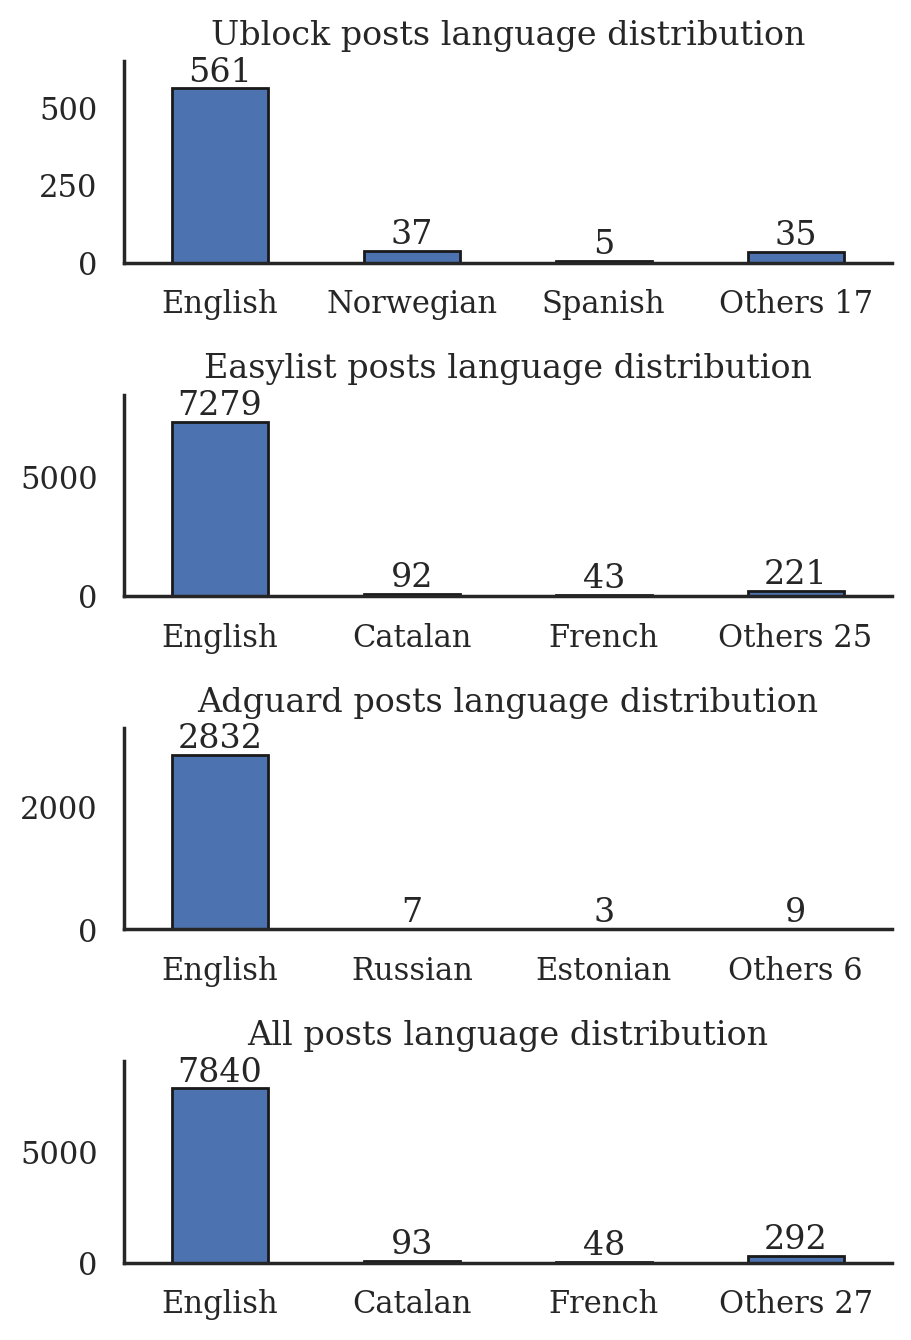

In [34]:
df_u = pd.read_csv(UBLOCK_LIST_OUTPUT_DIR.joinpath("ublock-data.csv"))
df_e = pd.read_csv(EASY_LIST_OUTPUT_DIR.joinpath("easylist-data.csv"))
df_adguard = pd.read_csv(ADGUARD_OUTPUT_DIR.joinpath("adguard-data.csv"))
df_all = pd.DataFrame({'lang': df_u.lang.values.tolist() + df_e.lang.values.tolist()})

def plot_langs(df, name, ax):
    langs = df.lang.value_counts()
    langs.index = [lang_iso_2.get(x, None) for x in langs.index]
    
    # get the top 3
    langs.sort_values()
    
    others_n = 0
    
    for i in langs.index[3:]:
        others_n += langs[i]
        
    langs = pd.Series(langs[langs.index[:3]].to_dict() | {f'Others {len(langs.index[3:])}': others_n})
    
    langs.plot.bar(ax=ax, edgecolor='k')
    ax.set_title(f"{name} posts language distribution")
    ax.set_xticklabels(ax.get_xticklabels(), rotation=0)  
    ax.bar_label(ax.containers[0])
    
    y_lim = list(ax.get_ylim())
    y_lim[1] = y_lim[1] * 1.1
    
    ax.set_ylim(y_lim )
    sns.despine(ax=ax, left=False, right=True)

    
    print(f"Number of unique languages in {name}: {len(df.lang.unique())}")
    print(f"The proportion of posts ranking first: {langs[langs.index[0]]/len(df)}")
    
fig, ax = plt.subplots(4,1)
fig.set_size_inches((5,7))

fig.tight_layout(pad=2.0)
plot_langs(df_u, "Ublock", ax[0])
plot_langs(df_e, "Easylist", ax[1])
plot_langs(df_adguard, "Adguard", ax[2])
plot_langs(df_all, 'All', ax[3])

### Fix time

In [76]:
df_u = pd.read_csv(UBLOCK_LIST_OUTPUT_DIR.joinpath("ublock-data.csv"))
df_e = pd.read_csv(EASY_LIST_OUTPUT_DIR.joinpath("easylist-data.csv"))
df_all = pd.DataFrame({'lang': df_u.lang.values.tolist() + df_e.lang.values.tolist()})

def get_commit_date(repo, commit):
    
    req = f"https://api.github.com/repos/{repo}/commits/{commit}"
    resp = requests.get(req, headers=headers).json()
    return resp['commit']['committer']['date']

def get_fixtime(df, dir):
    
    df = df[df.should_include == True]
    
    fixtime = df.progress_apply(lambda row: get_commit_date(row.repo, row.after_commit), axis=1)
    
    pd.DataFrame({
        'id': df.id,
        'create_time': df.created_at,
        'fix_time': fixtime
    }).to_csv(dir.joinpath("fixtime.csv"))
    
get_fixtime(df_u, UBLOCK_LIST_OUTPUT_DIR)
get_fixtime(df_e, EASY_LIST_OUTPUT_DIR)

100%|██████████| 1344/1344 [06:45<00:00,  3.32it/s]


In [137]:
def format_duration(hours):
    hours = int(hours)
    days = hours // 24
    remaining_hours = hours % 24
    duration_string = ""
    if days > 0:
        duration_string += f"{days} day{'s' if days > 1 else ''}, "
    if remaining_hours > 0:
        duration_string += f"{remaining_hours} hour{'s' if remaining_hours > 1 else ''}, "
    
    return duration_string

def stats_fixtime(dir, create_time_format = "%Y-%m-%dT%H:%M:%SZ"):
    
    df = pd.read_csv(dir.joinpath("fixtime.csv"))
    df.create_time = df.create_time.apply(lambda x: datetime.strptime(x, create_time_format).replace(tzinfo=None))
    df.fix_time = df.fix_time.apply(lambda x: datetime.strptime(x, "%Y-%m-%dT%H:%M:%SZ"))
    
    df['duration'] = (df.fix_time - df.create_time).apply(lambda x: x.total_seconds() / 3600)

    # av = df.duration.mean()
    # std = df.duration.std()
    
    # a = 0.27
    

    # df_normal = df[((df.duration - av) < a* std) & ((df.duration - av) > -a* std)]
    
    # y, labels = np.histogram(df_normal.duration.values, bins=10)
    # labels = [format_duration((labels[i]+ labels[i+1])/2) for i in range(len(labels)-1)]

    # pd.DataFrame({
    #     'hours': labels,
    #     'count': y
    # }).plot.bar(x='hours', y='count')
    
    # print(df[df.duration < 0])
    
    print(df.duration.describe())
    print()
    
    
print("Easylist")
stats_fixtime(EASY_LIST_OUTPUT_DIR, "%Y-%m-%dT%H:%M:%S%z")

print("Ublock")
stats_fixtime(UBLOCK_LIST_OUTPUT_DIR)

Easylist
count     1344.000000
mean       342.679756
std       4679.120769
min     -84219.406667
25%          6.257153
50%         23.496667
75%        103.671806
max      52802.213333
Name: duration, dtype: float64

Ublock
count      355.000000
mean       883.073856
std       3177.836386
min          0.015278
25%          0.898333
50%          5.093333
75%         18.858472
max      31679.807500
Name: duration, dtype: float64



In [62]:
import traceback
from bs4 import BeautifulSoup


def _has_fixing_commit(issue):
    EASY_LIST_ISSUE_URL = issue.issue_url
    doc = requests.get(EASY_LIST_ISSUE_URL,  headers={
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:102.0) Gecko/20100101 Firefox/102.0"
})
    try:
        doc = BeautifulSoup(doc.text, features="html.parser")
        _contents = doc.select(".content")
        if not len(_contents):
            print(EASY_LIST_ISSUE_URL)
            print(doc)
            return False
        
        post_content = _contents[0]

        if post_content is None:
            print(EASY_LIST_ISSUE_URL, "post_content is None")
            print(doc)
            return False
        
        # get commits
        
        for post in doc.select(".post"):
            # if the .profile-rank exists and it has "EasyList Author" in it, skip
            if (
                post.select_one(".profile-rank")
                and "EasyList Author" in post.select_one(".profile-rank").text
            ):
                _post_content = post.select_one(".content")
                urls = [
                    easylist._get_repo_and_commit_from_url(x.attrs["href"])
                    for x in _post_content.find_all("a")
                    if "github.com" in x.attrs["href"] and "commit" in x.attrs["href"]
                ]
                
                if len(urls) > 0:
                    return True
                
        
        return False
    except Exception as e:
        print(EASY_LIST_ISSUE_URL, "error")
        print(traceback.format_exc())
        return False

is_fixed = df_e[df_e.created_at.apply(lambda x: datetime.strptime(x.split("T")[0], "%Y-%m-%d").year) >= 2020].progress_apply(_has_fixing_commit, axis=1)


  0%|          | 0/967 [00:00<?, ?it/s]

100%|██████████| 967/967 [15:07<00:00,  1.07it/s]


In [64]:
is_fixed.value_counts(normalize=True)

True     0.567735
False    0.432265
dtype: float64

Number of Issues: 7900
Number of Included Issues: 1344
Earliest Post: 1970-01-01
Latest included Post: 1970-01-01
Latest Post: 1970-01-01
Number of Issues in last 3 years: 967
Number of Issues included in last 3 years: 486
Number of Issues: 638
Number of Included Issues: 367
Earliest Post: 1970-01-01
Latest included Post: 1970-01-01
Latest Post: 1970-01-01
Number of Issues in last 3 years: 611
Number of Issues included in last 3 years: 344
Number of Issues: 2851
Number of Included Issues: 2605
Earliest Post: 1970-01-01
Latest included Post: 1970-01-01
Latest Post: 1970-01-01
Number of Issues in last 3 years: 2122
Number of Issues included in last 3 years: 1980


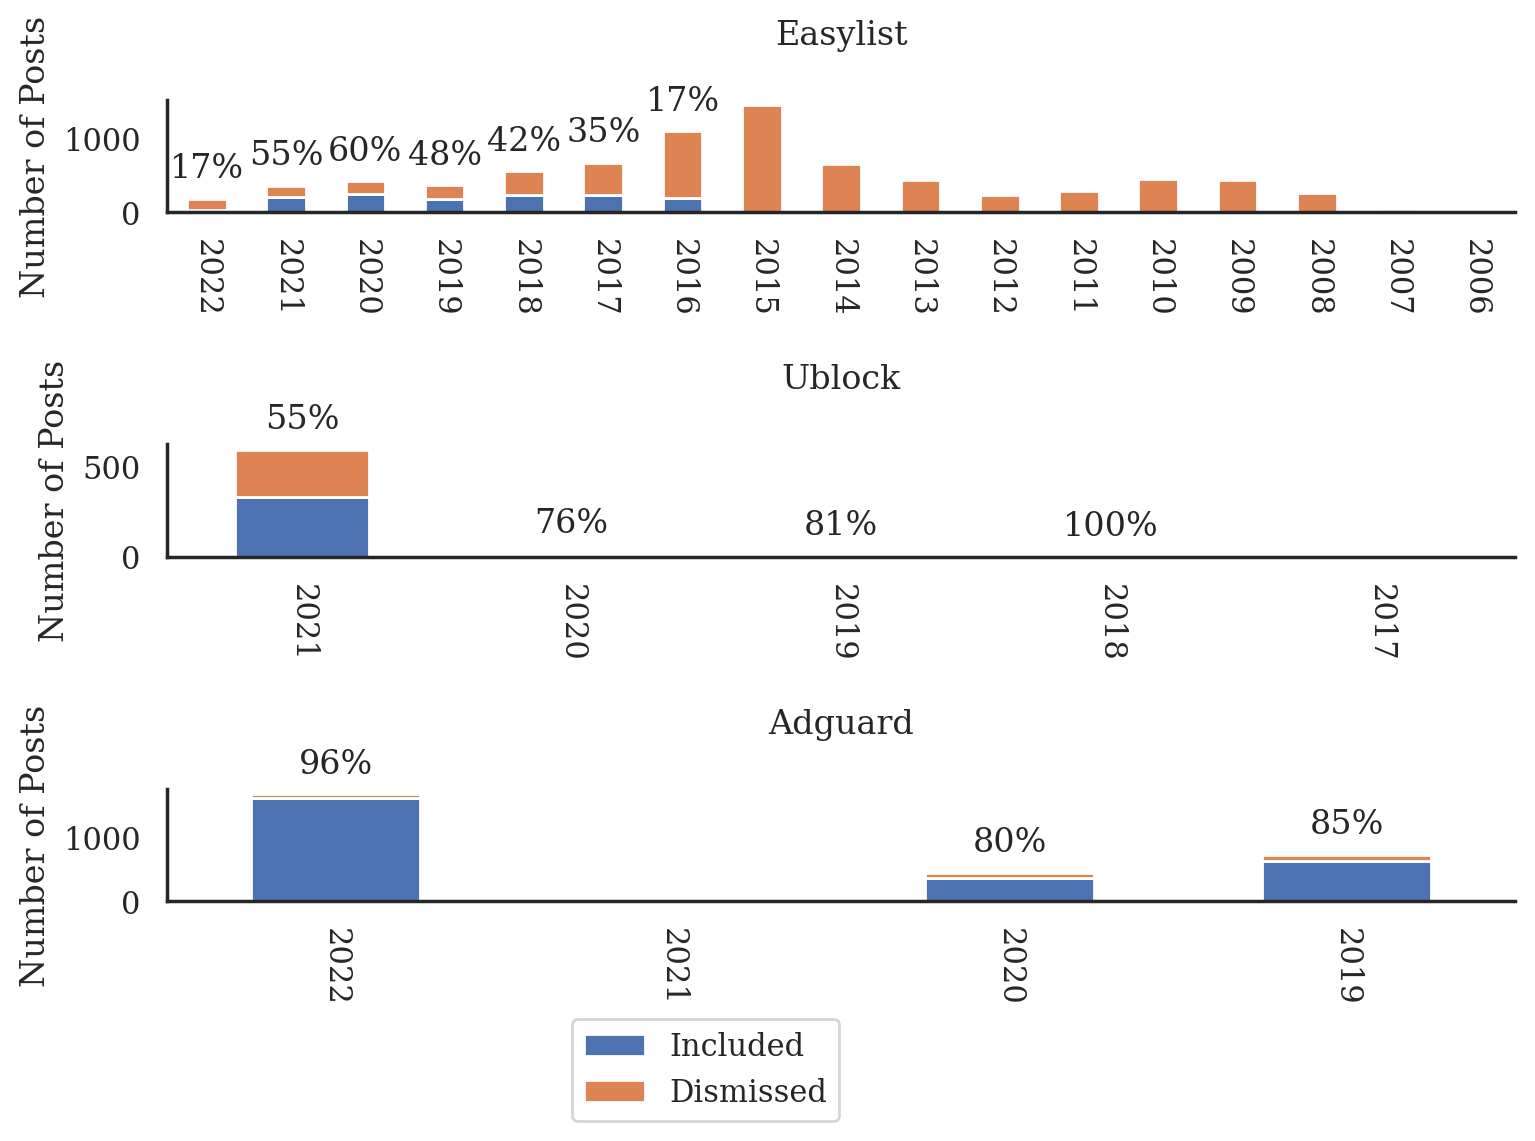

In [136]:
def included_bar(df, name, ax):
    
    print(f"Number of Issues: {len(df)}")
    print(f"Number of Included Issues: {len(df[df['should_include']])}")
    
    
    datetimes = df['created_at'].apply(lambda row: datetime.strptime(row.split("T")[0], "%Y-%m-%d").year).values
    datetimes_locked = df[df['should_include']]['created_at'].apply(lambda row: datetime.strptime(row.split("T")[0], "%Y-%m-%d").year).values

    # reproducibility over time
    
    
    datetimes_all = datetimes
    datetimes_true = datetimes_locked
    
    
    bins = max(datetimes_all) -  min(datetimes_all)
    y_all, x_all = np.histogram(datetimes_all, bins=bins)
    y_true, _ = np.histogram(datetimes_true, bins=bins, range=(min(datetimes_all), max(datetimes_all)))
    
    y_not = [y_all[i] - y_true[i] for i in range(len(y_all))]
    x = [ f"{int(x_all[i])}"  for i in range(len(x_all)-1)]
    labels =[(f"{int(y_true[i]/y_all[i] * 100 if y_all[i] != 0 else 0)}%" if y_all[i] >10 and y_true[i]/y_all[i] > 0.05 else "") for i in range(len(y_all))]
    
    y_true = y_true[::-1]
    y_not = y_not[::-1]
    x = x[::-1]
    labels=labels[::-1]
    
    df_time = pd.DataFrame(
        {
            'Included': y_true,
            'Dismissed': y_not,            
        },
        index = x
    )
    
    df_time.plot(kind='bar', stacked=True, ax=ax, legend=False)
    ax.set(xticklabels=x)
    ax.tick_params(axis='x', rotation=-90)
    ax.set_title(f"{name}", pad=20)
    ax.set_ylabel("Number of Posts")
    
    #labels are overlapping
    ax.bar_label(ax.containers[1], padding=5, labels = labels)
    
    sns.despine(ax=ax, left=False, right=True)
    
    print(f"Earliest Post: {datetime.fromtimestamp(min(datetimes)).date()}")
    print(f"Latest included Post: {datetime.fromtimestamp(max(datetimes_locked)).date()}")
    print(f"Latest Post: {datetime.fromtimestamp(max(datetimes)).date()}")
    print(f"Number of Issues in last 3 years: {len(df[df['created_at'].apply(lambda row: datetime.strptime(row.split('T')[0], '%Y-%m-%d').year) >= 2020])}")
    print(f"Number of Issues included in last 3 years: {len(df[(df['created_at'].apply(lambda row: datetime.strptime(row.split('T')[0], '%Y-%m-%d').year) >= 2020) & (df['should_include'])])}")
             
df_easylist = pd.read_csv(EASY_LIST_OUTPUT_DIR.joinpath("easylist-data.csv"))
df_ublock = pd.read_csv(UBLOCK_LIST_OUTPUT_DIR.joinpath("ublock-data.csv"))
df_adguard = pd.read_csv(ADGUARD_OUTPUT_DIR.joinpath("adguard-data.csv"))

df_adguard['created_at'] = df_adguard['created_at'].apply(lambda row: row.split(" ")[0])

fig, ax = plt.subplots(3,1)
fig.set_size_inches((9, 6))

fig.tight_layout(pad=5.0)
included_bar(df_easylist, "Easylist", ax[0])

included_bar(df_ublock, "Ublock", ax[1])

included_bar(df_adguard, "Adguard", ax[2])

plt.legend(
    bbox_to_anchor=(0.30, -1.05),
    loc='upper left',
    borderaxespad=0.0

)

plt.savefig("forums-out/included.pdf")

Number of Issues: 7900
Number of Included Issues: 1344
Earliest Post: 1970-01-01
Latest included Post: 1970-01-01
Latest Post: 1970-01-01
Number of Issues in last 3 years: 967
Number of Issues included in last 3 years: 486
Number of Issues: 638
Number of Included Issues: 367
Earliest Post: 1970-01-01
Latest included Post: 1970-01-01
Latest Post: 1970-01-01
Number of Issues in last 3 years: 611
Number of Issues included in last 3 years: 344
Number of Issues: 2851
Number of Included Issues: 2605
Earliest Post: 1970-01-01
Latest included Post: 1970-01-01
Latest Post: 1970-01-01
Number of Issues in last 3 years: 2122
Number of Issues included in last 3 years: 1980


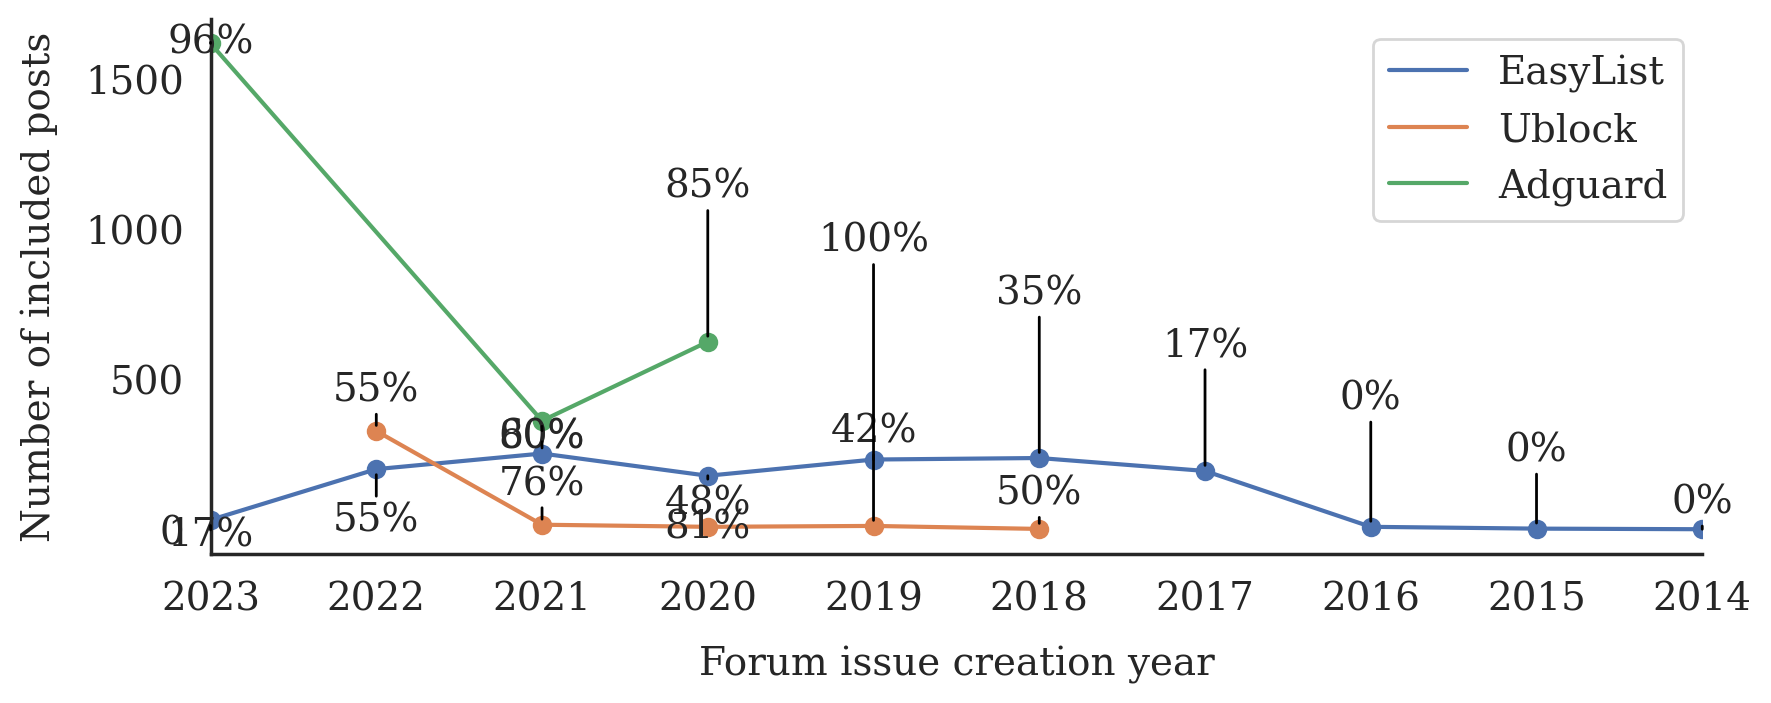

In [113]:
from adjustText import adjust_text
from scipy import interpolate

def included_bar(df, name, ax):
    
    print(f"Number of Issues: {len(df)}")
    print(f"Number of Included Issues: {len(df[df['should_include']])}")
    
    
    datetimes = df['created_at'].apply(lambda row: datetime.strptime(row.split("T")[0], "%Y-%m-%d").year).values
    datetimes_locked = df[df['should_include']]['created_at'].apply(lambda row: datetime.strptime(row.split("T")[0], "%Y-%m-%d").year).values

    # reproducibility over time
    
    
    datetimes_all = datetimes
    datetimes_true = datetimes_locked
    
    
    bins = max(datetimes_all) -  min(datetimes_all)
    y_all, x_all = np.histogram(datetimes_all, bins=bins)
    y_true, _ = np.histogram(datetimes_true, bins=bins, range=(min(datetimes_all), max(datetimes_all)))
    
    y_not = [y_all[i] - y_true[i] for i in range(len(y_all))]
    
    x = [ int(x_all[i]) for i in range(1, len(x_all))]
    
    ratios =[int(y_true[i]/y_all[i] * 100 if y_all[i] != 0 else 0) for i in range(len(y_all))]
    
    # remove points where y_all is 0
    y_true = [y_true[i] for i in range(len(y_all)) if y_all[i] > 0]
    y_not = [y_not[i] for i in range(len(y_all)) if y_all[i] > 0]
    x = [ x[i] for i in range(len(y_all)) if y_all[i] > 0]
    ratios = [ratios[i] for i in range(len(y_all)) if y_all[i] > 0]
    
    

    ax.plot(x, y_true, label=name)
    ax.scatter(x, y_true)
    
    # add labels for points
    texts = []
    
    x_float = [float(i) for i in x]
    y_float = [ float(i) for i in y_true]
    
    for i in range(len(x)):
        if y_true[i] > 0:
            texts.append(ax.text(x_float[i], y_float[i],
                f"{ratios[i]}%"))
            
            
    # reverse the x axis
    ax.set_xlim(ax.get_xlim()[::-1])
    
    sns.despine(ax=ax, left=False, right=True)
    
    print(f"Earliest Post: {datetime.fromtimestamp(min(datetimes)).date()}")
    print(f"Latest included Post: {datetime.fromtimestamp(max(datetimes_locked)).date()}")
    print(f"Latest Post: {datetime.fromtimestamp(max(datetimes)).date()}")
    print(f"Number of Issues in last 3 years: {len(df[df['created_at'].apply(lambda row: datetime.strptime(row.split('T')[0], '%Y-%m-%d').year) >= 2020])}")
    print(f"Number of Issues included in last 3 years: {len(df[(df['created_at'].apply(lambda row: datetime.strptime(row.split('T')[0], '%Y-%m-%d').year) >= 2020) & (df['should_include'])])}")
    
    # add virtual points along the plot to make the labels more readable
    f = interpolate.interp1d(x_float, y_float)
    xnew = np.linspace(min(x_float), max(x_float), num=100, endpoint=True)
    ynew = f(xnew)
    
    return texts, xnew.tolist(), ynew.tolist()
             
df_easylist = pd.read_csv(EASY_LIST_OUTPUT_DIR.joinpath("easylist-data.csv"))
df_ublock = pd.read_csv(UBLOCK_LIST_OUTPUT_DIR.joinpath("ublock-data.csv"))
df_adguard = pd.read_csv(ADGUARD_OUTPUT_DIR.joinpath("adguard-data.csv"))

df_adguard['created_at'] = df_adguard['created_at'].apply(lambda row: row.split(" ")[0])

# make for paper
plt.rcParams.update({'font.size':14})
# axes font size
plt.rc('axes', titlesize=14)
#ticks font size
plt.rc('xtick', labelsize=14)
plt.rc('ytick', labelsize=14)


fig, ax = plt.subplots(figsize=(10,5 ))
# fig.set_size_inches((9, 6))

fig.tight_layout(pad=5.0)

texts = []
x_float = []
y_float = []

_texts, _x_float, _y_float = included_bar(df_easylist, "EasyList", ax)
texts += _texts
x_float += _x_float
y_float += _y_float

_texts, _x_float, _y_float = included_bar(df_ublock, "Ublock", ax)
texts += _texts
x_float += _x_float
y_float += _y_float

_texts, _x_float, _y_float = included_bar(df_adguard, "Adguard", ax)
texts += _texts
x_float += _x_float
y_float += _y_float

adjust_text(texts, x=x_float, y=y_float, arrowprops=dict(arrowstyle='-', color='black'), autoalign='y', force_points=0.1, force_text=0.1, expand_points=(1.5, 1.5), expand_text=(1.5, 1.5), only_move={'points':'y', 'text':'y'}, )
plt.ylabel("Number of included posts", labelpad=10, fontsize=14)
plt.xlabel("Forum issue creation year", labelpad=10, fontsize=14)
plt.legend(fontsize=14)


# ax.set_yscale('log')
# cut the plot at 2014
ax.set_xlim(2023, 2014)

plt.savefig("forums-out/included.pdf")

# Adguard

In [ ]:
generate_rule_types_from_file(ADGUARD_OUTPUT_DIR.joinpath("adguard-data.csv"))

Number of Correctly Labeled Rules: 2605
Number of Unlabeled Rules: 0
Number of CSS Rules: 1522
Number of Network Rules: 670
Number of Mixed Rules: 413


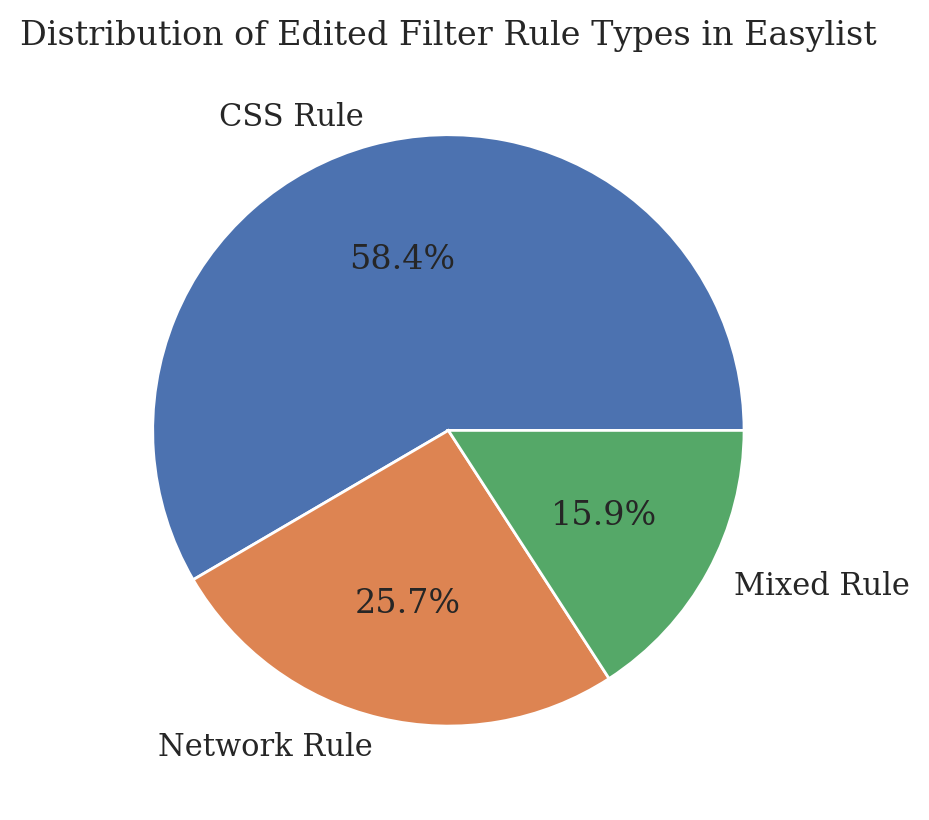

In [6]:
def stat():
    labels = pd.read_csv(ADGUARD_OUTPUT_DIR.joinpath("rule-types01.csv"))
    correct_labels = labels[(labels['rule'] == RuleType.NETWORK) | (labels['rule'] == RuleType.CSS) | (labels['rule'] == "XXX")]
    print(f"Number of Correctly Labeled Rules: {len(correct_labels)}")
    print(f"Number of Unlabeled Rules: {len(labels) - len(correct_labels)}")
    print(f"Number of CSS Rules: {len(correct_labels[correct_labels['rule'] == RuleType.CSS])}")
    print(f"Number of Network Rules: {len(correct_labels[correct_labels['rule'] == RuleType.NETWORK])}")
    print(f"Number of Mixed Rules: {len(correct_labels[correct_labels['rule'] == 'XXX'])}")
    p = correct_labels['rule'].value_counts()
    
    keys = {
        RuleType.CSS: "CSS Rule",
        RuleType.NETWORK: "Network Rule",
        "XXX": "Mixed Rule"
    }
    
    plt.pie(p.values, labels=[keys[a] for a in p.keys()], autopct='%1.1f%%')
    plt.title("Distribution of Edited Filter Rule Types in Easylist")
stat()

Easylist
total investigated:  170
total reproducible:  75

Ublock
total investigated:  57
total reproducible:  22

Adguard
total investigated:  183
total reproducible:  121



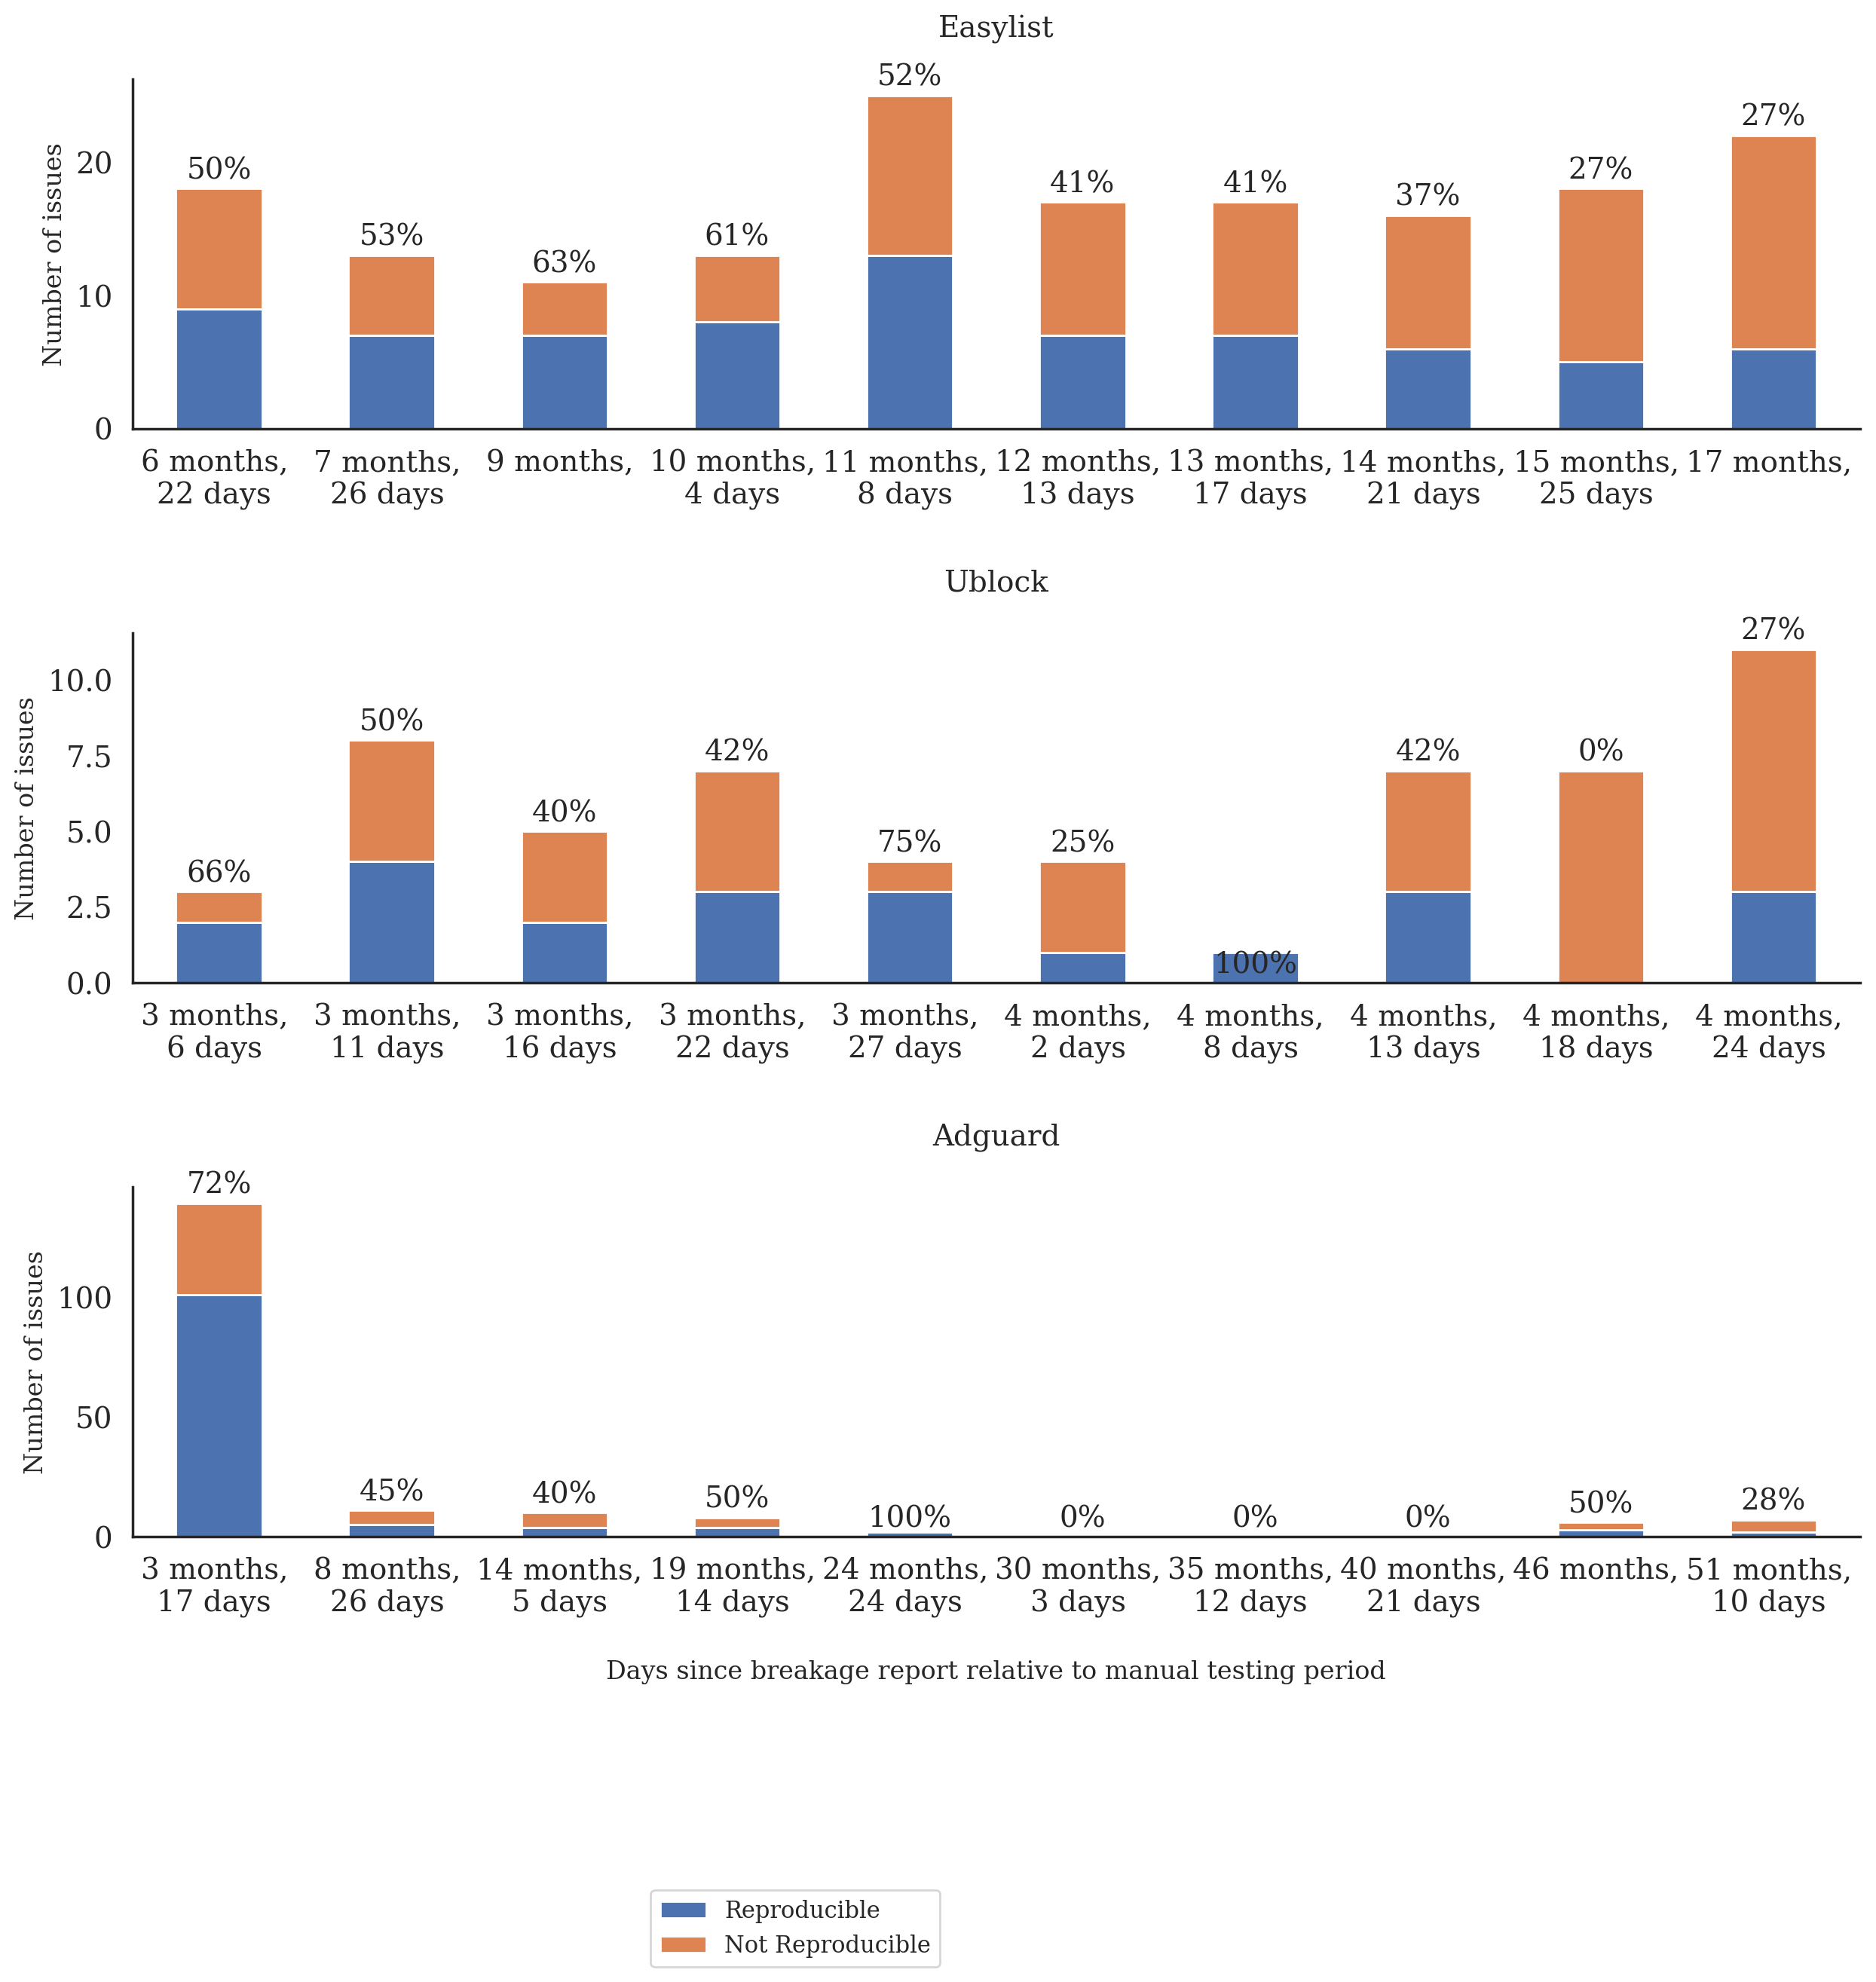

In [136]:
def to_month_days(days):
    
    months = days // 30
    remaining_days = days % 30
    
    duration_string = ""
    
    if months > 0:
        duration_string += f"{months} month{'s' if months > 1 else ''}, "
    if remaining_days > 0:
        duration_string += f"\n{remaining_days} day{'s' if remaining_days > 1 else ''} "
        
    return duration_string
    

def rep_bar(df, df_rep, name, ax, dt_relative):

    # reproducibility over time
    
    df_rep['id'] = df_rep['id'].astype('int64')
    df_rep['reproduce'] = df_rep['reproduce'].astype('bool')
    
    df_re_time = df_rep.merge(df, on='id')[['reproduce', 'created_at']]
    datetimes_all = df_re_time['created_at'].apply(lambda row: datetime.strptime(row.split("T")[0], "%Y-%m-%d").timestamp()).values
    datetimes_true = df_re_time[df_re_time['reproduce']]['created_at'].apply(lambda row: datetime.strptime(row.split("T")[0], "%Y-%m-%d").timestamp()).values
    
    
    bins = 10
    y_all, x_all = np.histogram(datetimes_all, bins=bins)
    y_true, _ = np.histogram(datetimes_true, bins=bins, range=(min(datetimes_all), max(datetimes_all)))
    
    y_not = [y_all[i] - y_true[i] for i in range(len(y_all))]
    x = [ to_month_days((dt_relative - datetime.fromtimestamp(x_all[i])).days)  for i in range(len(x_all)-1)]
    labels =[f"{int(y_true[i]/y_all[i] * 100) if y_all[i] != 0 else 0}%" for i in range(len(y_all))]
    
    y_true = y_true[::-1]
    y_not = y_not[::-1]
    x = x[::-1]
    labels=labels[::-1]
    
    df_time = pd.DataFrame(
        {
            'Reproducible': y_true,
            'Not Reproducible': y_not,            
        },
        index = x
    )
    
    df_time.plot(kind='bar', stacked=True, ax=ax, legend=False)
    ax.set(xticklabels=x)
    ax.tick_params(axis='x', rotation=0)

    ax.bar_label(ax.containers[1], padding=2, labels = labels)
    
    ax.set_title(f"{name}", pad=20)
    ax.set_ylabel("Number of issues")
    
    sns.despine(ax=ax, left=False, right=True)
    
    print(name)
    print("total investigated: ", len(df_rep))
    print("total reproducible: ", len(df_rep[df_rep['reproduce']]))
    print()
    
             
df_easylist = pd.read_csv(EASY_LIST_OUTPUT_DIR.joinpath("easylist-data.csv"))
df_easylist_rep = pd.read_csv(EASY_LIST_OUTPUT_DIR.joinpath("manual-reproduce.csv"))
df_ublock = pd.read_csv(UBLOCK_LIST_OUTPUT_DIR.joinpath("ublock-data.csv"))
df_ublock_rep = pd.read_csv(UBLOCK_LIST_OUTPUT_DIR.joinpath("repr.csv"))
df_adguard = pd.read_csv(ADGUARD_OUTPUT_DIR.joinpath("adguard-data.csv"))
df_adguard['created_at'] = df_adguard['created_at'].apply(lambda row: row.split(" ")[0])
df_adguard_rep = pd.read_csv(ADGUARD_OUTPUT_DIR.joinpath("manual-reproduce.csv"))

fig, ax = plt.subplots(3,1)
fig.set_size_inches((14, 12))

fig.tight_layout(pad=5.0)
rep_bar(df_easylist, df_easylist_rep, "Easylist", ax[0], datetime.strptime("2022-09-01", "%Y-%m-%d"))

rep_bar(df_ublock, df_ublock_rep, "Ublock", ax[1], datetime.strptime("2022-09-01", "%Y-%m-%d"))

rep_bar(df_adguard, df_adguard_rep, "Adguard", ax[2], datetime.strptime("2023-09-01", "%Y-%m-%d"))


# rep_bar(df_adguard, "Adguard", ax[2])

plt.legend(
    bbox_to_anchor=(0.30, -1.01),
    loc='upper left',
    borderaxespad=0.0
)

plt.xlabel("Days since breakage report relative to manual testing period", labelpad=20)
plt.savefig("forums-out/repr.pdf", bbox_inches='tight')

Number of Issues: 7900
Number of Included Issues: 1344
2021-04-09 00:00:00 510 days, 0:00:00 510
2021-05-13 04:54:00 475 days, 19:06:00 475
2021-06-16 09:48:00 441 days, 14:12:00 441
2021-07-20 14:42:00 407 days, 9:18:00 407
2021-08-23 19:36:00 373 days, 4:24:00 373
2021-09-27 00:30:00 338 days, 23:30:00 338
2021-10-31 04:24:00 304 days, 19:36:00 304
2021-12-04 09:18:00 270 days, 14:42:00 270
2022-01-07 14:12:00 236 days, 9:48:00 236
2022-02-10 19:06:00 202 days, 4:54:00 202
2022-03-17 00:00:00 168 days, 0:00:00 168
[475, 441, 407, 373, 338, 304, 270, 236, 202, 168]
Number of Issues before 4 months: 0
Number of Reproducible Issues before 4 months: 0
Number of Issues: 638
Number of Included Issues: 367
2022-04-10 00:00:00 144 days, 0:00:00 144
2022-04-15 07:12:00 138 days, 16:48:00 138
2022-04-20 14:24:00 133 days, 9:36:00 133
2022-04-25 21:36:00 128 days, 2:24:00 128
2022-05-01 04:48:00 122 days, 19:12:00 122
2022-05-06 12:00:00 117 days, 12:00:00 117
2022-05-11 19:12:00 112 days, 4:48

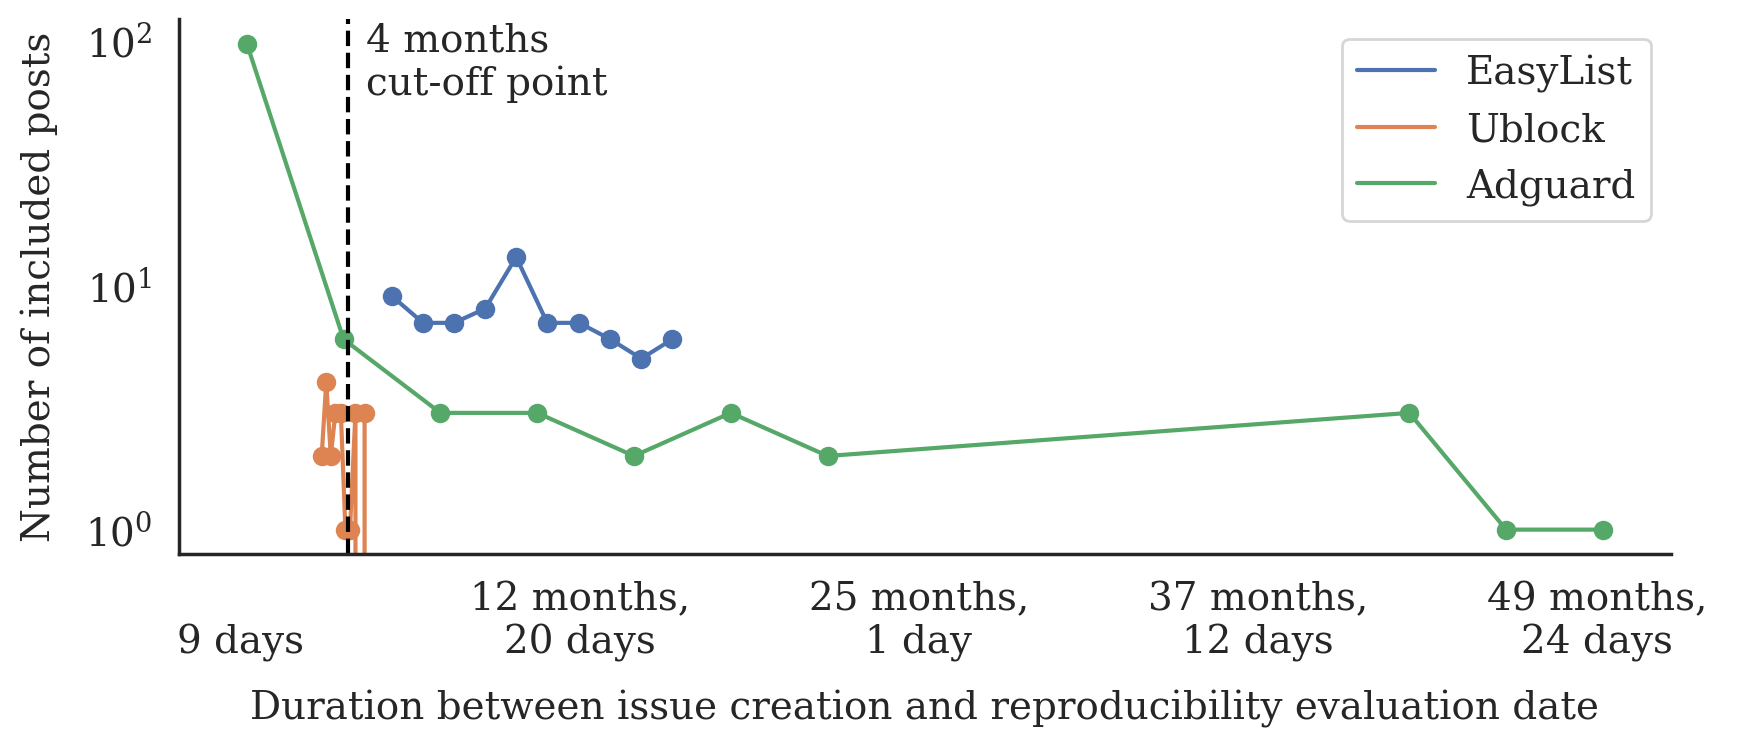

In [211]:
from datetime import timedelta
from adjustText import adjust_text
from scipy import interpolate

max_months = 60

def repr_bar(df, df_rep, name, ax, dt_relative, n_bins=10):

    max_date =  dt_relative - timedelta(days=max_months * 30)
    
    print(f"Number of Issues: {len(df)}")
    print(f"Number of Included Issues: {len(df[df['should_include']])}")
    
    df_re_time = df_rep.merge(df, on='id')[['reproduce', 'created_at']]
    
    datetimes_all = df_re_time['created_at'].apply(lambda row: datetime.strptime(row.split("T")[0], "%Y-%m-%d").timestamp()).values
    datetimes_true = df_re_time[df_re_time['reproduce'].astype(bool)]['created_at'].apply(lambda row: datetime.strptime(row.split("T")[0], "%Y-%m-%d").timestamp()).values

    # reproducibility over time
    bins = n_bins
    y_all, x_all = np.histogram(datetimes_all, bins=bins)
    y_true, _ = np.histogram(datetimes_true, bins=bins, range=(min(datetimes_all), max(datetimes_all)))
    
    y_not = [y_all[i] - y_true[i] for i in range(len(y_all))]
    

    x = [ (dt_relative - datetime.fromtimestamp(x_all[i]))  for i in range(1, len( x_all))]

    for _x in x_all:
        print(datetime.fromtimestamp(_x), dt_relative  - datetime.fromtimestamp(_x), (dt_relative - datetime.fromtimestamp(_x)).days)
    
    x =  [i.days for i in x]    
    print(x)

    ratios =[int(y_true[i]/y_all[i] * 100 if y_all[i] != 0 else 0) for i in range(len(y_all))]
    
    # remove points where y_all is 0
    y_true = [y_true[i] for i in range(len(y_all)) if y_all[i] > 0]
    y_not = [y_not[i] for i in range(len(y_all)) if y_all[i] > 0]
    x = [ x[i] for i in range(len(y_all)) if y_all[i] > 0]
    ratios = [ratios[i] for i in range(len(y_all)) if y_all[i] > 0]
    
    

    ax.plot(x, y_true, label=name)
    ax.scatter(x, y_true)
    
    # add labels for points
    texts = []
    
    x_float = [float(i) for i in x]
    y_float = [ float(i) for i in y_true]
    
    # for i in range(len(x)):
    #     if y_true[i] > 0:
    #         texts.append(ax.text(x_float[i], y_true[i],
    #             f"{ratios[i]}%"))
            
            
    # reverse the x axis
    # ax.set_xlim(ax.get_xlim()[::-1])
    
    sns.despine(ax=ax, left=False, right=True)
    
    # print(f"Earliest Post: {datetime.fromtimestamp(min(datetimes)).date()}")
    # print(f"Latest included Post: {datetime.fromtimestamp(max(datetimes_locked)).date()}")
    # print(f"Latest Post: {datetime.fromtimestamp(max(datetimes)).date()}")
    # print(f"Number of Issues in last 3 years: {len(df[df['created_at'].apply(lambda row: datetime.strptime(row.split('T')[0], '%Y-%m-%d').year) >= 2020])}")
    # print(f"Number of Issues included in last 3 years: {len(df[(df['created_at'].apply(lambda row: datetime.strptime(row.split('T')[0], '%Y-%m-%d').year) >= 2020) & (df['should_include'])])}")
    
    # add virtual points along the plot to make the labels more readable
    f = interpolate.interp1d(x_float, y_float)
    xnew = np.linspace(min(x_float), max(x_float), num=100, endpoint=True)
    ynew = f(xnew)
    
    # print reproducibility count before 4 months
    print(f"Number of Issues before 4 months: {len(df_re_time[df_re_time['created_at'].apply(lambda row: (dt_relative - datetime.strptime(row.split('T')[0], '%Y-%m-%d')).days) < 120])}")
    print(f"Number of Reproducible Issues before 4 months: {len(df_re_time[(df_re_time['created_at'].apply(lambda row: (dt_relative - datetime.strptime(row.split('T')[0], '%Y-%m-%d')).days) < 120) & (df_re_time['reproduce'])])}")
    
    
    return texts, xnew.tolist(), ynew.tolist()
             
df_easylist = pd.read_csv(EASY_LIST_OUTPUT_DIR.joinpath("easylist-data.csv"))
df_easylist_rep = pd.read_csv(EASY_LIST_OUTPUT_DIR.joinpath("manual-reproduce.csv"))
df_ublock = pd.read_csv(UBLOCK_LIST_OUTPUT_DIR.joinpath("ublock-data.csv"))
df_ublock_rep = pd.read_csv(UBLOCK_LIST_OUTPUT_DIR.joinpath("repr.csv"))
df_adguard = pd.read_csv(ADGUARD_OUTPUT_DIR.joinpath("adguard-data.csv"))
df_adguard['created_at'] = df_adguard['created_at'].apply(lambda row: row.split(" ")[0])
df_adguard_rep = pd.read_csv(ADGUARD_OUTPUT_DIR.joinpath("manual-reproduce.csv"))


# make for paper
plt.rcParams.update({'font.size':14})
# axes font size
plt.rc('axes', titlesize=14)
#ticks font size
plt.rc('xtick', labelsize=14)
plt.rc('ytick', labelsize=14)


fig, ax = plt.subplots(figsize=(10,5 ))
# fig.set_size_inches((9, 6))

fig.tight_layout(pad=5.0)

texts = []
x_float = []
y_float = []

_texts, _x_float, _y_float = repr_bar(df_easylist,df_easylist_rep, "EasyList", ax, datetime.strptime("2022-09-01", "%Y-%m-%d"))
texts += _texts
x_float += _x_float
y_float += _y_float
_texts, _x_float, _y_float = repr_bar(df_ublock,df_ublock_rep, "Ublock", ax, datetime.strptime("2022-09-01", "%Y-%m-%d"))
texts += _texts
x_float += _x_float
y_float += _y_float

_texts, _x_float, _y_float = repr_bar(df_adguard,df_adguard_rep, "Adguard", ax, datetime.strptime("2023-11-01", "%Y-%m-%d"), n_bins=15)
texts += _texts
x_float += _x_float
y_float += _y_float

n = 5
x_labels = [to_month_days(int(i)) for i in np.linspace(min(x_float), max(x_float), num=n, endpoint=True)]

plt.xticks(np.linspace(min(x_float), max(x_float), num=n, endpoint=True), x_labels, rotation=0)

# adjust_text(texts, x=x_float, y=y_float, arrowprops=dict(arrowstyle='-', color='black'), autoalign='y', force_points=0.1, force_text=0.1, expand_points=(1.5, 1.5), expand_text=(1.5, 1.5), only_move={'points':'y', 'text':'y'}, )
plt.ylabel("Number of included posts", labelpad=10, fontsize=14)
plt.xlabel("Duration between issue creation and reproducibility evaluation date", labelpad=10, fontsize=14)
plt.legend(fontsize=14)

# vertical line at 4 months
plt.axvline(x=120, color='black', linestyle='--')

# give the line a label
plt.text(140, 60, '4 months\ncut-off point', fontsize=14)

ax.set_yscale('log')
# cut the plot at 2014
# ax.set_xlim(2023, 2014)

plt.savefig("forums-out/reproducibility.pdf")
plt.show()

In [10]:
adguard_data = pd.read_csv(ADGUARD_OUTPUT_DIR.joinpath("adguard-data.csv"))

# get the number of issues newer than 6 2023
adguard_data['created_at'] = adguard_data['created_at'].apply(lambda row: datetime.strptime(row.split(" ")[0], "%Y-%m-%d"))

adguard_data = adguard_data[adguard_data['created_at'] >= datetime.strptime("2023-04-01", "%Y-%m-%d")]

print(f"Number of issues newer than 6 2023: {len(adguard_data)}")


Number of issues newer than 6 2023: 512


Easylist


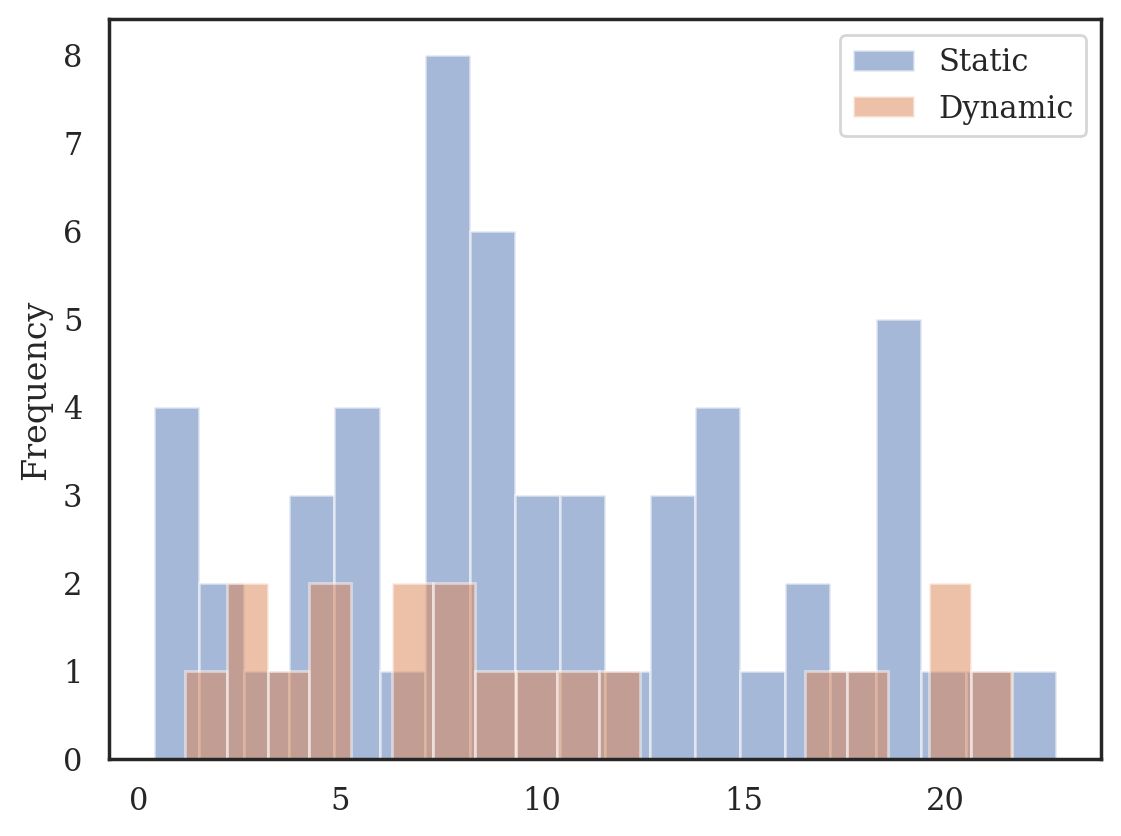

static 1 days 11:59:17.636363636 3 days 00:19:20.536815305
dynamic 8 days 16:05:15.578947368 21 days 02:45:50.990289859
total 74
frequency > 1 month 9
static frequency > 1 month 4 (7%)
dynamic frequency > 1 month 5 (26%)
Ublock


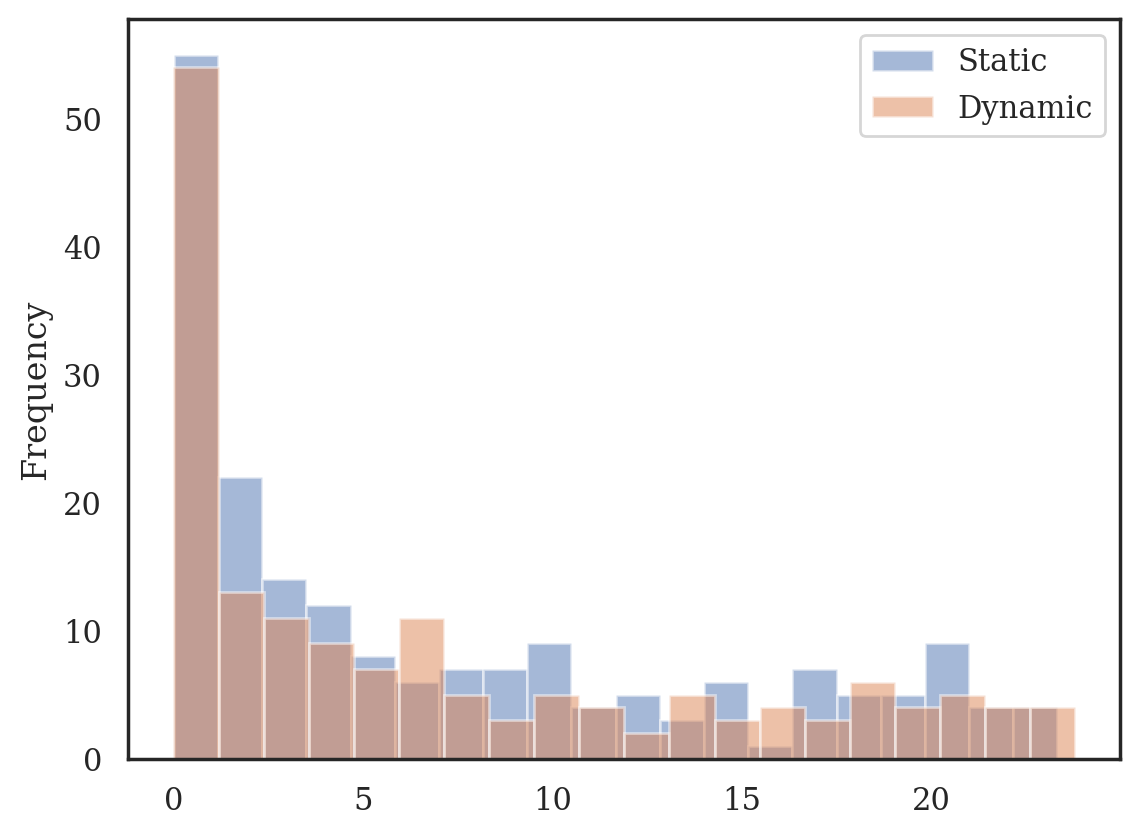

static 31 days 10:31:03.020725388 107 days 16:21:27.157484624
dynamic 43 days 04:13:49.783950617 156 days 23:46:42.142640310
total 355
frequency > 1 month 46
static frequency > 1 month 23 (12%)
dynamic frequency > 1 month 23 (14%)


In [67]:
from datetime import timedelta


def stat(df_bt, df_fix_time, create_time_format, breakage_type_label = "breakage-type"):
    
    df = df_fix_time.merge(df_bt, on='id')
    
    df.create_time = df.create_time.apply(lambda x: datetime.strptime(x, create_time_format).replace(tzinfo=None))
    df.fix_time = df.fix_time.apply(lambda x: datetime.strptime(x, "%Y-%m-%dT%H:%M:%SZ"))
    
    df['duration'] = (df.fix_time - df.create_time)
    
    
    df_static = df[df[breakage_type_label] == 'S']
    df_dynamic = df[df[breakage_type_label] == 'D']
    
    df_static.duration.apply(lambda row: row.seconds/3600).plot.hist(bins=20, alpha=0.5, label='Static', legend=True)
    df_dynamic.duration.apply(lambda row: row.seconds/3600).plot.hist(bins=20, alpha=0.5, label='Dynamic', legend=True)
    plt.show()
    
    print("static", df_static.duration.mean(), df_static.duration.std())
    print("dynamic", df_dynamic.duration.mean(), df_dynamic.duration.std())
    
    days = 5
    print("total", len(df))
    print("frequency > 1 month", len(df[df.duration > timedelta(days=days)]))
    
    n_static_more =  len(df_static[df_static.duration > timedelta(days=days)])
    n_dynamic_more = len(df_dynamic[df_dynamic.duration > timedelta(days=days)])
    
    n_static = len(df_static)
    n_dynamic = len(df_dynamic)
    
    print("static frequency > 1 month", n_static_more, f"({round(n_static_more/n_static * 100)}%)")
    print("dynamic frequency > 1 month", n_dynamic_more, f"({round(n_dynamic_more/n_dynamic * 100)}%)")
df_fix_time = pd.read_csv(EASY_LIST_OUTPUT_DIR.joinpath("fixtime.csv"))
df_bt = pd.read_csv(EASY_LIST_OUTPUT_DIR.joinpath("manual-breakage-type.csv")).dropna().astype({'id': 'int64'})
print("Easylist")
stat(df_bt, df_fix_time, "%Y-%m-%dT%H:%M:%S%z")

df_fix_time = pd.read_csv(UBLOCK_LIST_OUTPUT_DIR.joinpath("fixtime.csv"))
df_bt = pd.read_csv(UBLOCK_LIST_OUTPUT_DIR.joinpath("ublock-data.csv")).dropna().astype({'id': 'int64'})
print("Ublock")
stat(df_bt, df_fix_time, "%Y-%m-%dT%H:%M:%S%z", "label")

### Running Time

# Debugging

In [121]:


from BreakageClassifier.code.forums.utils import get_latest_commit_until, get_commit_date

issues = pd.read_csv("../BreakageClassifier/code/forums/adguard/data/adguard-data.csv")

get_latest_commit_until(
    "AdguardTeam/AdguardFilters",
    datetime.fromisoformat(issues[issues.id == 152339].iloc[0].created_at)
)

{'sha': 'f79030c30f416f51290bae4ce6824907cda9165f',
 'date': '2023-05-30T07:32:22Z'}

In [11]:
get_commit_date(
    "AdguardTeam/AdguardFilters",
    "f32676c1256ef33719801c8bae522f40f3a9bdec"
)

datetime.datetime(2023, 5, 30, 8, 46, 56)

In [122]:
issues.should_include.value_counts()

True     2605
False     246
Name: should_include, dtype: int64

In [117]:
issues[issues.should_include].sample(frac=0.1)[['id']].to_csv("forums-out/adguard/adguard-repr.csv", index=False)

In [128]:
issues[issues.should_include].sort_values(by='created_at', ascending=False)[['id']].to_csv("forums-out/adguard/adguard-repr-new.csv", index=False)